# Intro

In this example we propagate the orbits of the components of the Laser Guided Space Interferometer (LGSI). The initial conditions are chosen such that the interferometer is poiting in a certain direction (optical path lengths remain thesame for all mirrors for the first few hours). The laser guide star (LGS) is flying in a similar high Earth orbit but opposite direction so that it remains in front of the star.

We provide the (precomputed) manuevers neccesary to a) maintaing the pointing of the interferometer in the presence of Sun's perturbing gravity force, b) improve the uv coverage, and c) repoint the LGSI by changing the orbit of the LGS.

## Orbit Propagation
We use poliasto to propagte our orbit around Earth with Sun as a perturbing third body.
We work with one-hour increments in this notebook. However, behind the scenes, we make poliastro use one-minute increments for better precision.

The code below defines the "propagate_closed_loop_orbit" fucntion that will be used for all following calculations, as well as some other helper functions. Note that all orbits begin at a fixed time hence they are affected by the sun in a mutually consistent manner.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Sun
from poliastro.core.perturbations import third_body
from poliastro.core.propagation import func_twobody

from poliastro.ephem import build_ephem_interpolant
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate, cowell

epoch = Time(2464594.202273755, format="jd", scale="tdb")

body_r = build_ephem_interpolant(Sun, 365.2425 * u.day, (epoch.value * u.day, epoch.value * u.day + 80 * u.day), rtol=1e-2)

def f_three_bodies(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = third_body(
        t0,
        state,
        k,
        k_third=Sun.k.to(u.km ** 3 / u.s ** 2).value,
        perturbation_body=body_r,
    )

    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

def propagate_orbit_one_hour(r0, v0, epoch):
    tofs = TimeDelta(np.linspace(0, u.hour, num=60))
    
    initial = Orbit.from_vectors(
        Earth,
        r0 * u.m,
        v0 * u.m/u.s,
        epoch=epoch
    )

    rr = propagate(
        initial,
        tofs,
        method=cowell,
        rtol=1e-6,
        f=f_three_bodies,
    )

    return np.array(rr.xyz[:,-1], dtype=float)*1000, np.array(rr.differentials["s"][-1]._values.tolist(), dtype=float)*1000

def propagate_closed_loop_orbit(r, v, dvs):
    rs = [r]
    for i in range(len(dvs)):
        epoch = Time(
            2464594.202273755 + i/24, format="jd", scale="tdb"
        )

        r,v = propagate_orbit_one_hour(rs[-1], v+dvs[i], epoch)
        rs.append(r)
        
    return np.array(rs)

/usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## Analyzing formation maintenance (first 6 hours)
### Laser Guide Star (LGS) and interferometer positioning

For the example in this notebook we chose some convenient starting position for the LGS spacecraft and the interferometer. Here the "interferomter" is jusr a nominal position in space rather than any of the componenets that comprise it (combiner and mirror-cubesats).

The LGS in manuevering in space, hence it is given a set of thrusts, or delta-v vectors, for the first six hours (later in this example we provide a much longer time series). The nominal interferometer position drifts in open loop (zero delta-v).

(3, 6)


Text(0.5, 0, 'z [m]')

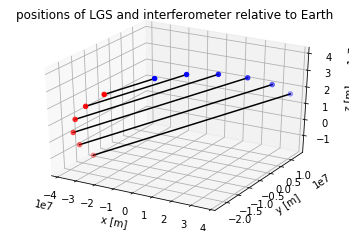

In [2]:
r0_interferometer = np.array([36553680.122232765, 13110001.132682526, 16621226.943997538])
r0_lgs = np.array([-36553680.122232765, -13110001.132682526, -16621226.943997538])
v0_interferometer = np.array([-747.8642420733553, -1373.9962753573782, 2631.7475036829655])
v0_lgs = np.array([-719.9713170037995, -1351.544122384381, 2648.6823327646603])

dvs_lgs = np.array([[11.524653064750597, -6.215470170245856, 1.898299503893403], [6.8605283843208875, -0.8992531997743181, -0.5925101261701045], [2.8045716870512862, 4.969053372497665, -2.839222921655394], [3.017857540283073, 4.3621928993323795, -7.473051036429393], [2.569021338974769, 4.713760397070592, -9.045308341484176]])
dvs_zero = np.zeros(dvs_lgs.shape)

rs_interferometer = propagate_closed_loop_orbit(r0_interferometer, v0_interferometer, dvs_zero)
rs_lgs = propagate_closed_loop_orbit(r0_lgs, v0_lgs, dvs_lgs)

ax = plt.axes(projection='3d')

ax.scatter3D(*rs_interferometer.T, color="b")
ax.scatter3D(*rs_lgs.T, color="r")
print(rs_lgs.T.shape)
for i in range(len(rs_lgs)):
    ax.plot3D(*np.stack([rs_lgs[i],rs_interferometer[i]], axis=1), color="k")
ax.set_title("positions of LGS and interferometer relative to Earth")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")

### Interferometer pointing
The interferometer is aligned by the LGS that is located tens of thousands of kilometers away. The line connecting between the two is the direction at which the interferometer is pointing at any given moment. We also define two perpendicular directions as follows:
1. a direction aligned with the initial velocity of the interferometer after projecting out the pointing direction
2. the remaining orthogonal direction

In [3]:
direction = (r0_lgs - r0_interferometer)/np.linalg.norm(r0_lgs - r0_interferometer)
perp_direction_1 = v0_interferometer - direction.dot(v0_interferometer)*direction
perp_direction_1 /= np.linalg.norm(perp_direction_1)
perp_direction_2 = np.cross(direction, perp_direction_1)

### Initial combiner and mirror positioning
Below we provide the initial positions of the combiner and the five cubesat-mirrors.

Text(0.5, 0, 'z [m]')

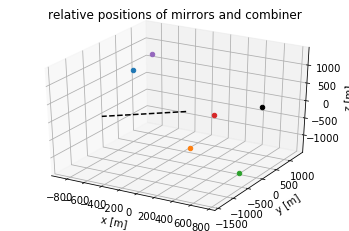

In [4]:
r0_combiner = r0_interferometer + [749.4224943295121, 268.7808646541089, 340.7679148465395]
v0_combiner = v0_interferometer + [0.014855606776677632, 0.028304829062108183, -0.05499614693189869]

r0_mirror1 = r0_interferometer + [-350.3044986948371, -667.4455715138465, 1296.8435400072485]
r0_mirror2 = r0_interferometer + [524.3166087418795, -1404.6537882294506, -45.16446628421545]
r0_mirror3 = r0_interferometer + [674.349983766675, -200.67821203731, -1324.7567152548581]
r0_mirror4 = r0_interferometer + [-107.54539845883846, 1280.6278323885053, -773.5802105683833]
r0_mirror5 = r0_interferometer + [-740.8166953474283, 992.1497393921018, 846.6578520983458]

r0_mirrors = [r0_mirror1, r0_mirror2, r0_mirror3, r0_mirror4, r0_mirror5]

v0_mirror1 = v0_interferometer + [-0.09534384451353617, -0.034195131800288436, -0.04335354667637148]
v0_mirror2 = v0_interferometer + [-0.029462868263749442, -0.010566876851271445, -0.013396982689300785]
v0_mirror3 = v0_interferometer + [0.07713479052040384, 0.027664442751301976, 0.035073756027486525]
v0_mirror4 = v0_interferometer + [0.07713479052040384, 0.027664442751301976, 0.035073756027486525]
v0_mirror5 = v0_interferometer + [-0.029462868263749442, -0.010566876851271445, -0.013396982689300785]

v0_mirrors = [v0_mirror1, v0_mirror2, v0_mirror3, v0_mirror4, v0_mirror5]

ax = plt.axes(projection='3d')

ax.scatter3D(*(r0_combiner - r0_interferometer), color="k")
ax.plot3D(*np.stack([np.zeros(3), 1e3*direction], axis=1), color="k", linestyle="--")
for i_mirror in range(5):
    ax.scatter3D(*(r0_mirrors[i_mirror] - r0_interferometer))
ax.set_title("relative positions of mirrors and combiner")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")

### Open-loop drift due to the Sun
Here we propagate the positions of the combiner and the mirrors without applying any thrust. We plot optical path length from the star (which is in front of the LGS) to each mirror and then to the combine. The length is counted from the nominal position of interferometer, and it varies by several meters between the mirrors in open loop. The drift is due to the Sun acting slightly differently on each memeber of the formation.

We also plot how the mirrors appear to move when seen from the direction of the star (uv coverage).

/tmp/ipykernel_282373/3041401624.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_282373/3041401624.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


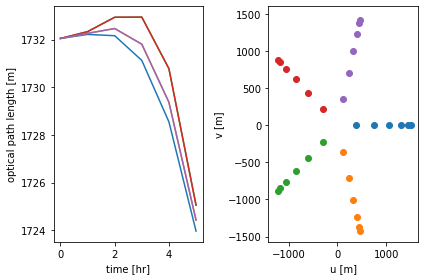

In [6]:
rs_combiner = propagate_closed_loop_orbit(r0_combiner, v0_combiner, dvs_zero)

for i_mirror in range(5):
    rs = propagate_closed_loop_orbit(r0_mirrors[i_mirror], v0_mirrors[i_mirror], dvs_zero)
    
    drs_nominal = rs - rs_interferometer[:len(rs)]
    drs_combiner = rs - rs_combiner
    delays_1 = -drs_nominal.dot(direction)
    delays_2 = np.linalg.norm(drs_combiner, axis=1)
    delays = delays_1 + delays_2
    plt.subplot(121)
    plt.ylabel("optical path length [m]")
    plt.xlabel("time [hr]")
    plt.plot(delays)
    
    u_disp = drs_nominal.dot(perp_direction_1)
    v_disp = drs_nominal.dot(perp_direction_2)
    plt.subplot(122)
    plt.scatter(u_disp, v_disp)
    plt.ylabel("v [m]")
    plt.xlabel("u [m]")
    
plt.tight_layout()

### Closing the loop on optical path length
We now introduce manuevers for the combiner and each of the mirrors to ensure the same optical path length. For simplicity, we only applied impulsive thrusts once an hour. The closed-loop optical path length differences are reduced from meters to millimeters.

/tmp/ipykernel_282373/991940702.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_282373/991940702.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


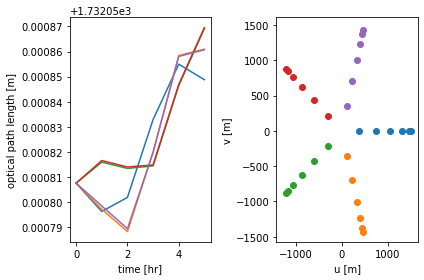

In [7]:
dvs_combiner = np.array([[0.0002091375083856686, 5.061125847591466e-05, 0.00016089876003914369], [0.00010555058625157557, -4.229582223878461e-05, 0.00026397298601768396], [-0.0001708987304559785, -5.496320025391162e-05, -9.394713464975887e-05], [8.188550917020957e-06, 0.0001648362379666801, -0.0004303962202358775], [0.0005340700424408319, 0.0003855168569141448, -0.00027734399934861936]])
    
rs_combiner = propagate_closed_loop_orbit(r0_combiner, v0_combiner, dvs_combiner)

dvs_mirror1 = np.array([[0.00010815202504012399, 0.00012353123620360284, -0.00017871017679989523], [0.00027500477418522724, 0.00017460197167338615, -7.953567419936835e-05], [0.0001395378088451133, -1.0550348309583957e-05, 0.00022572613258182907], [-0.0002066338041338087, -0.0002058573009060416, 0.00025941548568852334], [-0.0005891001526750299, -0.0002928044563977283, -4.955261934979619e-05]])
dvs_mirror2 = np.array([[-6.843681181982425e-05, 0.00022993296831810308, 1.5939009120921877e-05], [-3.0446260980369564e-05, 0.00027054877674897944, 5.5503081972504116e-05], [5.469888236074692e-05, -2.6610384820649868e-05, 6.048605738836028e-05], [3.942510584768857e-05, -0.0002600152741320322, 6.642186103904518e-06], [-4.87589177192894e-05, -0.00034329698950950557, -0.0001095359940539343]])
dvs_mirror3 = np.array([[-0.0001513279305430835, 1.8292675752668076e-05, 0.00018807558064735946], [-0.0002954720410716414, -7.78553191659114e-06, 0.00011256559700609879], [-0.00010713783932206498, -5.997013640087976e-06, -0.00019004774416801174], [0.00022996624060162246, 4.53877254601038e-05, -0.00025738151738408235], [0.000558436927763922, 8.121506729142286e-05, -2.0454893442415168e-05]])
dvs_mirror4 = np.array([[-2.595792063456438e-05, -0.00021890867065055028, 9.981594677059612e-05], [-0.0001536956836280823, -0.0002757361667647791, 1.2880599509614985e-05], [-0.00012200102112563713, 2.2809152049927995e-05, -0.00017925877681181898], [0.00010209824895879414, 0.00028818280116632154, -0.00016689752048809435], [0.00039366924786810514, 0.00039370874666246763, 9.599618128865596e-05]])
dvs_mirror5 = np.array([[0.00013441467963569052, -0.0001538641325944856, -0.00012686705419957377], [0.0001989458828044034, -0.0001629915399509279, -0.00010578583340437004], [3.06416123856031e-05, 2.0014345562730803e-05, 7.794869134849128e-05], [-0.00016747402472709575, 0.0001328437240464551, 0.00015305147739421592], [-0.00031535753828802423, 0.0001623262965845332, 7.88850318009369e-05]])

dvs_mirrors = [dvs_mirror1, dvs_mirror2, dvs_mirror3, dvs_mirror4, dvs_mirror5]

for i_mirror in range(5):
    rs = propagate_closed_loop_orbit(r0_mirrors[i_mirror], v0_mirrors[i_mirror], dvs_mirrors[i_mirror])
    
    drs_nominal = rs - rs_interferometer[:len(rs)]
    drs_combiner = rs - rs_combiner
    delays_1 = -drs_nominal.dot(direction)
    delays_2 = np.linalg.norm(drs_combiner, axis=1)
    delays = delays_1 + delays_2
    plt.subplot(121)
    plt.ylabel("optical path length [m]")
    plt.xlabel("time [hr]")
    plt.plot(delays)
    
    u_disp = drs_nominal.dot(perp_direction_1)
    v_disp = drs_nominal.dot(perp_direction_2)
    plt.subplot(122)
    plt.scatter(u_disp, v_disp)
    plt.ylabel("v [m]")
    plt.xlabel("u [m]")
    
plt.tight_layout()

### Closing the loop on optical path length and uv coverage
Here, we change the thrusts to also make the rotate mirrors rotate around the axis poiting towards the star to increase uv coverage of the interferometer. The optical path differences still remain within millimeters of each other.

/tmp/ipykernel_282373/3926408715.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_282373/3926408715.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


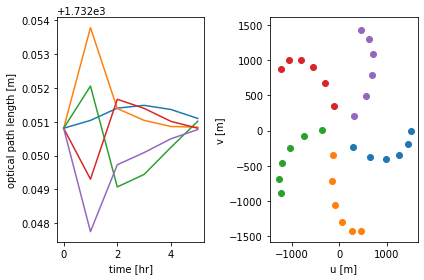

In [8]:
dvs_mirror1 = np.array([[0.025537279205696813, -0.04305706505301009, -0.019642411591042484], [0.002616530891411544, 0.011564867622312363, -0.0003096426578029297], [0.0022308065922357033, 0.017244053793403956, 0.0071665941324857265], [0.000510295635582044, 0.019788499921496186, 0.014481363460591819], [-0.0023871161573672237, 0.01906120205466082, 0.020422087696106695]])
dvs_mirror2 = np.array([[0.02995875952878714, 0.016644580101485503, -0.04372208271255131], [0.018651176781172427, 0.012876688425974744, 0.018665532870495227], [0.015155976941862546, 0.007166642393616291, 0.02407167445430867], [0.010765471900163895, -0.0005861882844541229, 0.026495641116295793], [0.006006909048499026, -0.00916753402290252, 0.025817856593588404]])
dvs_mirror3 = np.array([[-0.0070226239050394735, 0.05334369559119694, -0.007379801482345958], [0.008908865029216909, -0.0036070429564467777, 0.011844293794927949], [0.007134654783334965, -0.012814938285449159, 0.007708754057191542], [0.006142042760762958, -0.020150547106721983, 0.0018916433860929121], [0.006099041244526597, -0.024726443670559286, -0.004468188915714459]])
dvs_mirror4 = np.array([[-0.034299843046462664, 0.016323370458534783, 0.03916063172728201], [-0.013146698208408202, -0.015106303661320108, -0.011346519801973947], [-0.010747472381923756, -0.015086769037419972, -0.019308546343615354], [-0.006969862556572059, -0.011867452435818146, -0.025327244584946132], [-0.0022375381758846825, -0.006114235336239144, -0.028579396495429708]])
dvs_mirror5 = np.array([[-0.014176719135848533, -0.04325557271726477, 0.03158193372421082], [-0.017035561219001252, -0.005729537617977647, -0.018858022212476844], [-0.013778219266870144, 0.003490713103591489, -0.01964358825665774], [-0.010450572255579044, 0.012816254660965002, -0.017546547572381742], [-0.0074824131290387634, 0.020948174996782174, -0.01319700002239444]])

dvs_mirrors_uv_coverage = [dvs_mirror1, dvs_mirror2, dvs_mirror3, dvs_mirror4, dvs_mirror5]

for i_mirror in range(5):
    rs = propagate_closed_loop_orbit(r0_mirrors[i_mirror], v0_mirrors[i_mirror], dvs_mirrors_uv_coverage[i_mirror])
    
    drs_nominal = rs - rs_interferometer[:len(rs)]
    drs_combiner = rs - rs_combiner
    delays_1 = -drs_nominal.dot(direction)
    delays_2 = np.linalg.norm(drs_combiner, axis=1)
    delays = delays_1 + delays_2
    plt.subplot(121)
    plt.ylabel("optical path length [m]")
    plt.xlabel("time [hr]")
    plt.plot(delays)
    
    u_disp = drs_nominal.dot(perp_direction_1)
    v_disp = drs_nominal.dot(perp_direction_2)
    plt.subplot(122)
    plt.scatter(u_disp, v_disp)
    plt.ylabel("v [m]")
    plt.xlabel("u [m]")
    
plt.tight_layout()

### Delta-v estiamtes for formation maintenance
We can now compare our rough delta-v estiamtes required for maintaining the optical-path lengths of the cubestas and increasing the uv coverage.

Increasing uv coverage is much more expensive and requires on average about 0.2 m/s per cubesat (or less for more cubesats). However, it is neccesary only when performing observations. Keeping the cubestas at the right distances from the combiner between observation only requires about 0.001 m/s per hour per cubesat.

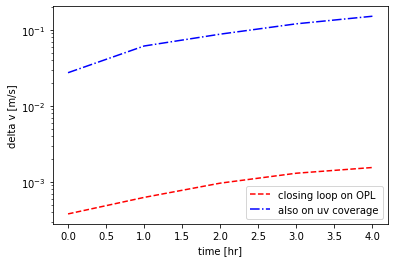

In [9]:
mean_delta_v_mirrors = np.mean(np.linalg.norm(dvs_mirrors, axis=2), axis=1)
mean_delta_v_mirrors_uv_coverage = np.mean(np.linalg.norm(dvs_mirrors_uv_coverage, axis=2), axis=1)

plt.plot(np.cumsum(mean_delta_v_mirrors), "r--", label="closing loop on OPL")
plt.plot(np.cumsum(mean_delta_v_mirrors_uv_coverage), "b-.", label="also on uv coverage")
plt.yscale("log")
plt.xlabel("time [hr]")
plt.ylabel("delta v [m/s]")
plt.legend()

## Analyzing repointing (47 days)
The LGS needs to be manuevered such that it appear ahead of different stars as viewed from the interferometer (repointing). We note that the pointing drifts on its own due to the different influence of the Sun on the LGS and th interferometer as they fly in oposite directions. This drift can be exploited to reduce fuel consumption.

### Star targets
First, we provide a list of stars that are bright, large and close enough to produce high-resolution images with a 3 km baseline interferometer and five 20 cm mirrors.

In [10]:
star_names = ['Alpha Aquilae', 'Alpha Arietis', 'Alpha Aurigae', 'Alpha Bootis', 'Alpha Canis Majoris', 'Alpha Canis Minoris', 'Alpha Carinae', 'Alpha Cassiopeiae', 'Alpha Centauri', 'Alpha Ceti', 'Alpha Serpentis', 'Alpha Tauri', 'Alpha Ursae Minoris', 'Beta Andromedae', 'Beta Bootis', 'Beta Cancri', 'Epsilon Corvi', 'Epsilon Cygni', 'Epsilon Geminorum', 'Epsilon Leporis', 'Epsilon Ophiuchi', 'Epsilon Pegasi', 'Epsilon Scorpii', 'Epsilon Virginis', 'Eta Ceti', 'Gamma Hydrae', 'Gamma Hydri', 'Gamma Leonis', 'Gamma Phoenicis', 'Gamma Sagittae', 'G Scorpii', 'Alpha Scorpii', 'Eta Draconis', 'Iota Aurigae', 'Lambda Velorum', 'Theta Centauri', 'Beta Leporis', 'Beta Ophiuchi', 'Beta Pegasi', 'Beta Ursae Minoris', 'Delta Andromedae', 'Delta Canis Majoris', 'Alpha Herculis', 'Alpha Hydrae', 'Alpha Indi', 'Alpha Lyncis', 'Alpha Lyrae', 'Alpha Orionis', 'Alpha Persei', 'Alpha Phoenicis', 'Mu Geminorum', 'Mu Ursae Majoris', 'Mu Velorum', 'Nu Hydrae', 'Nu Ursae Majoris', 'Pi Herculis', 'Pi Hydrae', 'Pi Puppis', 'Theta Eridani', 'Zeta Arae', 'Eta Geminorum', 'Eta Pegasi', 'Eta Serpentis', 'Gamma Andromedae', 'Gamma Aquilae', 'Gamma Cephei', 'Gamma Crucis', 'Gamma Draconis', 'Gamma Eridani', 'Delta Draconis', 'Delta Ophiuchi', 'Delta Virginis', 'Epsilon Boötis', 'Psi Ursae Majoris', 'Rho Persei', 'Sigma Canis Majoris', 'Sigma Librae', 'Tau Puppis', 'Tau Sagittarii', 'Iota Draconis', 'Kappa Ophiuchi', 'Lambda Sagittarii', 'Beta Ceti', 'Beta Columbae', 'Beta Corvi', 'Beta Cygni', 'Beta Draconis', 'Beta Geminorum', 'Beta Gruis', 'Beta Herculis', 'Zeta Cephei', 'Zeta Cygni', 'Zeta Hydrae']
star_ras = np.array([297.69582729166666, 31.79335708333333, 79.17232795833334, 213.9154166666667, 101.28715533333333, 114.82549791666668, 95.98795783333334, 10.126837916666666, 219.90205833333331, 45.569887791666666, 236.06697629166666, 68.98016279166666, 37.954541666666664, 17.433016166666665, 225.4865099166667, 124.12883583333334, 182.5311690833333, 311.5528431666666, 100.98302608333333, 76.365272375, 244.5803739166667, 326.04648391666666, 252.5408333333333, 195.54415770833333, 17.1474645, 199.73040495833334, 56.80975258333333, 154.99312733333335, 22.091363625000003, 299.6892859583333, 267.464503375, 247.35191541666669, 245.99785808333334, 74.24842120833334, 136.998991125, 211.67061466666667, 82.0613465, 265.8681360416666, 345.94357275000004, 222.67635750000002, 9.831979916666667, 107.09785866666668, 258.66188750000003, 141.89684708333334, 309.39180004166667, 140.2637530833333, 279.23473479166665, 88.792939, 51.080708708333326, 6.5710475, 95.74011191666666, 155.58224900000002, 161.69241154166667, 162.406203125, 169.619736, 258.76180983333336, 211.59290620833332, 109.28565325, 44.565330083333336, 254.65505070833333, 93.71940416666666, 340.75057262499996, 275.32750233333337, 30.974801208333332, 296.564917875, 354.83688333333333, 187.791498375, 269.1515411666667, 59.50736229166667, 288.13875820833334, 243.58641054166668, 193.90086920833332, 221.24675, 167.41586949999999, 46.29414104166667, 105.42978245833334, 226.01756699999999, 102.48403524999999, 286.73503737500005, 231.23239429166668, 254.41707437499997, 276.9926696666667, 10.89737875, 87.73997041666667, 188.5968118333333, 292.68035833333334, 262.60817375, 116.32895779166667, 340.666876125, 247.55499812500003, 332.71366250000005, 318.2341080833333, 133.84844225])
star_decs = np.array([8.868321194444444, 23.462417555555554, 45.997991472222225, 19.182222222222222, -16.71611586111111, 5.224987555555556, -52.69566138888889, 56.53733111111111, -60.83399269444445, 4.089738777777778, 6.425628694444445, 16.50930236111111, 89.2641111111111, 35.62055763888889, 40.39056683333333, 9.185544722222222, -22.619767222222222, 33.97025694444444, 25.131125416666666, -22.371034416666667, -4.692509583333333, 9.87500863888889, -34.29333333333334, 10.959150416666667, -10.182265833333334, -23.171514277777778, -74.2389635, 19.84148522222222, -43.318236166666665, 19.492146694444443, -37.04330486111111, -26.432002611111113, 61.51421386111111, 33.166099583333335, -43.43259091666667, -36.36995475, -20.759441055555556, 4.567304305555556, 28.08278711111111, 74.15550394444445, 30.86102175, -26.393207611111112, 14.390277777777778, -8.6586025, -47.291500722222224, 34.39256236111111, 38.78368894444444, 7.407064, 49.86117930555555, -42.30598719444444, 22.51358275, 41.499519194444446, -49.42025677777778, -16.193648888888887, 33.09430852777778, 36.80916230555555, -26.68236177777778, -37.097471166666665, -40.30467936111111, -55.99014452777778, 22.5068, 30.221245055555556, -2.8988268333333336, 42.32972841666667, 10.613261333333334, 77.632275, -57.11321344444445, 51.48889561111111, -13.508519388888889, 67.66154044444444, -3.6943225555555554, 3.3974703333333336, 27.07422222222222, 44.498486666666665, 38.84027619444444, -27.9348305, -25.28196127777778, -50.614567694444446, -27.670421916666665, 58.966065111111114, 9.375031277777778, -25.4216985, -17.986606305555554, -35.76830977777778, -23.39676038888889, 27.959677777777777, 52.30138869444445, 28.02619888888889, -46.88457644444444, 21.489611333333333, 58.201258333333335, 30.226915472222224, 5.945565388888889])

### Open-loop drift
We plot the stars and the pointing on the LGSI as it changes over time in open loop (no thursts applied). The pointing changes but doesn't come close to stars other than the first one (Gamma Hydrae).

Text(0, 0.5, 'declination [deg]')

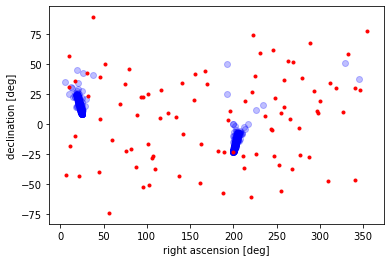

In [11]:
dvs_zero = np.zeros((1116, 3))

rs_interferometer = propagate_closed_loop_orbit(r0_interferometer, v0_interferometer, dvs_zero)
rs_lgs = propagate_closed_loop_orbit(r0_lgs, v0_lgs, dvs_zero)

directions = (rs_lgs - rs_interferometer)/np.linalg.norm(rs_lgs - rs_interferometer, axis=1, keepdims=True)

ra = np.arctan2(directions[:,1],directions[:,0])
dec = np.arctan2(directions[:,2], directions[:,0]*np.cos(ra) + directions[:,1]*np.sin(ra))
ra = ra + 2*np.pi*(ra<0)

plt.scatter(np.degrees(ra), np.degrees(dec), alpha=0.25, color="b")
plt.scatter(star_ras, star_decs, marker=".", color="r")

plt.xlabel("right ascension [deg]")
plt.ylabel("declination [deg]")

### Closing the loop on LGS position
Fiding suitable star targets and manuevers is a a multi-step optimization problem which we skip for brevity. Instead we present an example of a set of hourly thrusts that bring the LGS to point at four different stars (marked by crosses). The code below propagates the LGS (with thrusts) and the nominal interferometer position (no thrust) for about 47 days.

Text(0, 0.5, 'declination [deg]')

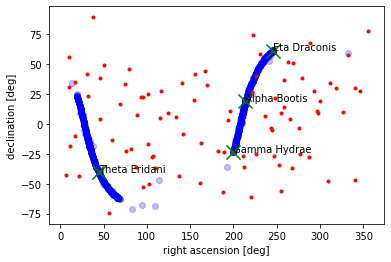

In [12]:
dvs_lgs = np.array([[11.524653064750597, -6.215470170245856, 1.898299503893403], [6.8605283843208875, -0.8992531997743181, -0.5925101261701045], [2.8045716870512862, 4.969053372497665, -2.839222921655394], [3.017857540283073, 4.3621928993323795, -7.473051036429393], [2.569021338974769, 4.713760397070592, -9.045308341484176], [-0.011714082608154826, -0.12213821134173987, -0.05882705885577106], [-0.0033615350888768895, -0.1618349897834982, -0.06319843574520219], [0.004357163737805819, -0.19149047477177902, -0.059856627904332396], [0.011715530389700024, -0.2078259732169337, -0.050329844968424194], [0.018123533615132366, -0.20880379534980126, -0.03707121307285367], [0.022130907874493875, -0.1940596290892945, -0.022761608071901775], [0.021794856237535395, -0.1650477139712184, -0.009566594827665276], [0.015321969609324266, -0.12483135594992437, 0.0014037439702646569], [0.001771794916341427, -0.07755902623194741, 0.010242700531576596], [-0.018434584389666483, -0.02776820550068428, 0.017959172224451817], [-0.04339348960316757, 0.020291793834456492, 0.025879457102411456], [-0.07003321412336246, 0.06315192088364073, 0.03497532710600997], [-0.0947569065348148, 0.09834677958031453, 0.04536213827890955], [-0.11420825877807728, 0.1243831391883911, 0.0561236714049128], [-0.12594265511440683, 0.14053886561805237, 0.06549186853525417], [-0.12884563551829747, 0.1466043805900514, 0.07129751223544671], [-0.12323186580487748, 0.1426649449430196, 0.07154562899923403], [-0.11064367290792966, 0.1289853018481552, 0.0649604682372489], [-0.0934284816978019, 0.10601603733417074, 0.051373556639919576], [-0.07420498637486904, 0.07450458733985246, 0.03187491601469283], [-0.05533435458320775, 0.03566727507300297, 0.008698092913991358], [-0.038502526889478035, -0.00863768152348698, -0.015142302746068382], [-0.024496892553031533, -0.055803279183203554, -0.036397704137710714], [-0.013225740204604562, -0.10249644896044921, -0.05221498417658936], [-0.003980681507229929, -0.14485676913884438, -0.06071583292554582], [0.004117551735057931, -0.17888373797520116, -0.06138327904196459], [0.011611063300821092, -0.20097525102462738, -0.05513586954798856], [0.01829835800355391, -0.2085226826477606, -0.044037085920643405], [0.023090649401831684, -0.20042254376308222, -0.030693253000194543], [0.024225029251747496, -0.17735599093603913, -0.017507679010663194], [0.019805179135838777, -0.1417331966563178, -0.006031835341339518], [0.008504341949002875, -0.09729431574118298, 0.0033606014854390565], [-0.00981852270335051, -0.048468601622744974, 0.011364227965567507], [-0.03382107314779295, 0.0003306441494112909, 0.019252151079589858], [-0.06081413201751138, 0.04529039298698018, 0.02820521679763855], [-0.08728843036440988, 0.08353816550954875, 0.03871370968597773], [-0.10965846520350137, 0.11321111909280511, 0.05025399665742788], [-0.12500061676234434, 0.13331321711656205, 0.061324531123815695], [-0.1315951138306365, 0.14346666742108888, 0.06980040283352199], [-0.1291641861014513, 0.14366579124268292, 0.07347954465809937], [-0.1187909047508619, 0.13411247568532345, 0.07066293014482376], [-0.10257635210362284, 0.11517037336810561, 0.06062597034924434], [-0.0831358422140254, 0.08743526597008705, 0.0438798454767558], [-0.06305090488543824, 0.05188782578905564, 0.02217196497504028], [-0.04438957812138756, 0.010074440926121158, -0.001775404090554892], [-0.028389470236839288, -0.0357492062415563, -0.024743227919441328], [-0.015368154797539753, -0.08257807151332505, -0.04362384350525756], [-0.004882753360173394, -0.1267763777430568, -0.05603791411965943], [0.0038947308374457012, -0.16438364999947908, -0.06081915018489236], [0.011682010459412542, -0.19159350184729412, -0.05823342285295265], [0.01861988329094268, -0.20533514688147592, -0.04984674571456704], [0.024002532168263417, -0.20383485850708774, -0.03804741380151215], [0.026334371217553183, -0.1870075970236596, -0.025342452378041693], [0.023741100764384775, -0.15655045681142138, -0.013644897457180347], [0.014625770232827037, -0.11568518239843452, -0.003794741106706755], [-0.0016524074697940702, -0.06860514539140698, 0.004516579862864951], [-0.02432780053499364, -0.019777855959301555, 0.012399976622371885], [-0.05118052924675889, 0.02670705379311063, 0.021145917336604293], [-0.0789156644309744, 0.06758854474726524, 0.031567759102802656], [-0.10384399567538276, 0.10061407199966636, 0.04354621766374494], [-0.12265194051007886, 0.12447441020832978, 0.055914052069716245], [-0.13304755835626356, 0.13858496100340134, 0.06669084459285558], [-0.13413580248492982, 0.14282575351151228, 0.0735709838342464], [-0.12646911159632424, 0.13733431854935413, 0.07451316401799649], [-0.11180329734558504, 0.12240710591324228, 0.06827721538033588], [-0.09264535848429237, 0.09852291741837856, 0.05478690372252831], [-0.07170670137393692, 0.0664664270614421, 0.035246002781092405], [-0.051378549454371286, 0.027504841281485806, 0.01198622094000091], [-0.03333340749873401, -0.016444252107471462, -0.011926418274183706], [-0.01833106481993042, -0.06272081986511913, -0.03325655635404646], [-0.006270264295999649, -0.10796737483605089, -0.04922792627176336], [0.0035230454968215273, -0.14835252715639588, -0.05808040039033837], [0.011840194897741666, -0.17997847227495653, -0.059415721970133506], [0.0190952612727152, -0.1994267540886576, -0.05422181330446267], [0.02495617098586254, -0.204340885016019, -0.04453855798517826], [0.028254033056987458, -0.19390393646734946, -0.03283560482286642], [0.02724747199034787, -0.16906812813914893, -0.021282159315548305], [0.020192004375462, -0.13244639305725014, -0.011149648378502894], [0.00603417712650051, -0.08787382775272698, -0.0025583955844498546], [-0.015019794761923088, -0.03975313197037771, 0.005343817010317539], [-0.04127841440405595, 0.007635004815473503, 0.01385061518353418], [-0.06977464557139326, 0.050678812385075905, 0.024025299707313104], [-0.09684487609903984, 0.08672993744179207, 0.03613900870864106], [-0.11889163543850127, 0.11413229269165351, 0.04940588301878254], [-0.1331071531373167, 0.13205369360472127, 0.062080099993262694], [-0.13797674565738063, 0.14022906626537218, 0.07185774853886645], [-0.1334675597624454, 0.13872074350555305, 0.07644780417005459], [-0.12089975464084521, 0.12776928206475993, 0.07415295744114245], [-0.10256685901599627, 0.10776581093173548, 0.06432148520505016], [-0.08121136754831491, 0.0793377253625933, 0.047575702772650545], [-0.059473888233051574, 0.04350990218748111, 0.025774227641571546], [-0.03942717841459266, 0.0018845631805634573, 0.0017153682836895336], [-0.022285607561874105, -0.04322625880350717, -0.021365495418004053], [-0.00834811497005075, -0.08878052628719053, -0.04041133801850822], [0.0028122274382601053, -0.1311495740205961, -0.0531465702842315], [0.011955397933704901, -0.16644736886113515, -0.05852731593598793], [0.019682712866675205, -0.1910228298680141, -0.05691225599770108], [0.025998853315968858, -0.20203734310063012, -0.04988192174642134], [0.030091196740917727, -0.19800031816256006, -0.03972900912311269], [0.030441768032049246, -0.17911552682026294, -0.028755268023342342], [0.025279038098214267, -0.14732019735200533, -0.018597285918929996], [0.013241599408669903, -0.10597992520544365, -0.00981521522661229], [-0.0059762490620088515, -0.059309859870659364, -0.0018924003546560747], [-0.03124011834962204, -0.011680994169547858, 0.006362139995970578], [-0.06000517760407807, 0.03300148592012834, 0.01617230205242333], [-0.08876004700936724, 0.07170376707260968, 0.02816101744980478], [-0.11374186913678667, 0.10239822005519102, 0.04194770779968069], [-0.13170489580517925, 0.12396498164433094, 0.05609685964285212], [-0.1405356774231756, 0.1359574152336371, 0.06840882825614293], [-0.13958060622242882, 0.13834292661680977, 0.07644352112250562], [-0.12964550766982047, 0.13130848713245713, 0.07812069856213845], [-0.11270831265405705, 0.11518014414399967, 0.07224480705738681], [-0.09143846660729413, 0.09046390863959863, 0.05883897398149984], [-0.06863968595707519, 0.057981232854420174, 0.0392234834333338], [-0.04673261452980369, 0.019048923273338524, 0.01582576892123382], [-0.027378322160107684, -0.024359950881557124, -0.008243322253080837], [-0.011315484373930922, -0.06954058549136169, -0.029769601268893733], [0.0015556369299402886, -0.11312480497957168, -0.0460588733168784], [0.011861212148924582, -0.1513293129798823, -0.05546736582715528], [0.020292710974577494, -0.18038155289010863, -0.05770348179360667], [0.027131096340121136, -0.1970692344838849, -0.05380164701180109], [0.03192007608435313, -0.1993059119070406, -0.045747380256864936], [0.033430556228335205, -0.18657014450495923, -0.03584122581225405], [0.0299743633289848, -0.1600824289388479, -0.02599207947692134], [0.01999654841460471, -0.12264402797762107, -0.01717828443734576], [0.002752698366376154, -0.07816190733258332, -0.009270411085532665], [-0.021177571367490575, -0.030985434741356545, -0.0012775899260403748], [-0.04974182797757357, 0.014762569728450884, 0.008085291394381973], [-0.07969846507811154, 0.055691369416274915, 0.019732193842027217], [-0.10724490586670826, 0.08938922049295267, 0.03368726606302083], [-0.12879405615766312, 0.11441224813520756, 0.048882925314095285], [-0.1416778588305905, 0.1300922671049507, 0.06331932009090324], [-0.1446076382643117, 0.13627402300523375, 0.07451233619983395], [-0.1378108261903821, 0.1330839740089656, 0.08008640044905138], [-0.12285377745992689, 0.12079789663891323, 0.07835241752427523], [-0.10222633948943115, 0.09983186101722775, 0.06873681700298744], [-0.07879897583689471, 0.07084288028407756, 0.05197480974814773], [-0.055271887657223406, 0.034897423879525866, 0.030033599279198124], [-0.03372543414289406, -0.006351263417693388, 0.005781378062890297], [-0.015357758921778196, -0.05054338057139387, -0.01753733332502262], [-0.00046052206354417084, -0.09461326749447568, -0.036920684660136774], [0.011363331074233046, -0.1349574613471391, -0.05019467786957551], [0.020792985138326028, -0.16778557388426327, -0.056425851396975375], [0.028306627226040174, -0.18962297434601472, -0.05604302108680062], [0.033776728616533996, -0.19788004694567454, -0.05061028563784175], [0.03630089037371808, -0.19135764534375144, -0.042291196984665574], [0.03436786317537457, -0.17054532830066255, -0.03315369576455876], [0.026345116424181154, -0.13760589705576257, -0.024541569809514645], [0.01114258618921888, -0.09602538105324307, -0.016735104437862414], [-0.011182644206106904, -0.05001326111452512, -0.009025446661643574], [-0.039113042333317125, -0.0038178668746028663, -0.000168687617976621], [-0.06977906374774148, 0.03886071218527449, 0.010961167939676804], [-0.09946526958644829, 0.07522897414301426, 0.02476796860044218], [-0.12435493146115746, 0.10348981681881915, 0.04058853612369591], [-0.14129195578488649, 0.12271258364299488, 0.05670691556417268], [-0.14836090593220613, 0.13258500230188522, 0.07070031806146707], [-0.14516420084129356, 0.13315696533625299, 0.07999583685849437], [-0.13277002251058959, 0.12466017262234194, 0.08247827634929815], [-0.11338267993676768, 0.10744633013309983, 0.07699988564163901], [-0.08983563894323061, 0.08204519537051475, 0.06368343969592295], [-0.06502632650740915, 0.04931106423301846, 0.04396232203305035], [-0.04140853224739409, 0.010604508493392001, 0.02035333180302845], [-0.0206395641098557, -0.032055032034182966, -0.003994874198167953], [-0.003448869237150485, -0.07593133962826933, -0.025893526533259305], [0.010247245497651424, -0.11766308350337124, -0.042728211218746745], [0.02101327977436925, -0.15353534444511038, -0.05295962833369424], [0.029432402534553585, -0.17992095467348587, -0.056380331305239194], [0.03565392074097027, -0.19382979123022523, -0.05404005268047796], [0.03911150455619226, -0.19345326689033157, -0.04783525240891402], [0.038542346179638934, -0.17856217171140873, -0.03986649547289627], [0.03234602540567796, -0.1506304656689818, -0.03176263556087063], [0.019192695739167695, -0.11262379002480499, -0.024205139060859342], [-0.0013240839705039534, -0.06849255645820707, -0.01682738186858124], [-0.02823464359933859, -0.022505389947869606, -0.008524771228809971], [-0.05912312825118142, 0.0213946343262768, 0.0019487644492312832], [-0.09048307359753292, 0.06005175953913212, 0.015328721634704069], [-0.11839031287496986, 0.09129678600912823, 0.03136958390498592], [-0.139287915129105, 0.11389769180476542, 0.048707930938683495], [-0.15066539368739945, 0.1273460106181678, 0.06508367923670515], [-0.15147345067270318, 0.1315904375917122, 0.07783174496956813], [-0.14220803386456898, 0.12681566283820242, 0.08449353787307928], [-0.12468571978996519, 0.1133274374881081, 0.08338912762565238], [-0.10159444508291325, 0.09156199931375018, 0.0740215178043972], [-0.07593461413596884, 0.06220077964243086, 0.05723402514995339], [-0.05047043119700176, 0.026344963299309458, 0.03509524652944243], [-0.027298239748989966, -0.01431101497702912, 0.01053581567699675], [-0.007612551666545443, -0.05737319729839188, -0.013195068070021916], [0.00828688864542275, -0.09976963704258984, -0.03314864182712303], [0.020752271644691227, -0.137941813007164, -0.047240891432180826], [0.030371745020786687, -0.16821446476244295, -0.05462647484678723], [0.037499327091626074, -0.187304904223311, -0.05577297003654148], [0.04188654158072143, -0.1928800427113291, -0.052192256758121135], [0.04256492566630609, -0.18402879620396584, -0.04588554839176331], [0.03806258184465877, -0.16151148076347785, -0.038663820432730686], [0.026920982697870292, -0.12769188433882084, -0.031570308297891446], [0.008351214740357079, -0.08614689721605412, -0.024614353326152003], [-0.017208247324853813, -0.041051351410109585, -0.01691724005804684], [-0.04785182630317539, 0.0034925543752034292, -0.007211455074984336], [-0.08039258677766689, 0.04400495671275088, 0.005501904074261387], [-0.11092623910561913, 0.0779391641030435, 0.021383983436482717], [-0.13560000847852674, 0.10372813401781887, 0.03947344578233937], [-0.15136352563553943, 0.12062553646329426, 0.05776592616761906], [-0.15651110498448031, 0.12844665035444752, 0.0736127102181123], [-0.15090808729891647, 0.12731684873400725, 0.08430741919371391], [-0.1358880884948427, 0.11750615358996301, 0.08769860066131749], [-0.11388312207903442, 0.09938596842149187, 0.08268256495528795], [-0.08789265134290175, 0.073503474377079, 0.06947504127033645], [-0.060912622816855756, 0.040737926101701516, 0.049613805302158594], [-0.03543898741903103, 0.0024830823971336885, 0.025696457667917554], [-0.013138695929989168, -0.03920931551215648, 0.0009041707781156564], [0.0052516355259542066, -0.08158905825472695, -0.021598302823183455], [0.019783238708036537, -0.12132124860576897, -0.039265339961123635], [0.030946704756243195, -0.1547785501013234, -0.05064024771000938], [0.039213251745748474, -0.1784944520147665, -0.055568278012339906], [0.04460874523488952, -0.18970852200830324, -0.05507770641951228], [0.046477542342030546, -0.1868867376396693, -0.05094053813845806], [0.04355350949136007, -0.17007700927429328, -0.045030765090989515], [0.034358063403675754, -0.1409816210307718, -0.038685312392851036], [0.01781678165709905, -0.10269975593674087, -0.032293699684085575], [-0.006118599680174049, -0.0591945158157585, -0.025271441064504515], [-0.03608134644436881, -0.014628379731651311, -0.016427903736607456], [-0.0692974116933515, 0.027252055196780985, -0.004584864345078909], [-0.1020087982315948, 0.06353338619553241, 0.010790589641552469], [-0.13018584489076543, 0.09228856801684046, 0.029166747455717918], [-0.15031606304181305, 0.11249198236967542, 0.048875178171003154], [-0.1600563844671855, 0.12378715318847032, 0.06739136640305815], [-0.1586018624760315, 0.12621865666699125, 0.0818668657021167], [-0.1467183501463147, 0.12002193267960759, 0.08975670400688496], [-0.1264727017983023, 0.10552574242702577, 0.08938410015833803], [-0.10075223348553823, 0.08317920625738456, 0.08031964157777166], [-0.07269195235300197, 0.053679434403380445, 0.06350388677899442], [-0.04512943956325128, 0.018151025774453045, 0.041096375206254136], [-0.020191189951572975, -0.021684955666207404, 0.016083295435371233], [0.0009143633301070137, -0.06341813467913729, -0.008281418780712929], [0.01786135349297235, -0.1039899765781475, -0.029092213761168877], [0.03094265412117788, -0.13990618922435466, -0.04433400310056003], [0.04064888519158519, -0.1676220811740109, -0.05321834272963905], [0.047214845632514345, -0.1840547093192494, -0.056214044610078534], [0.05028859017753688, -0.1871245861941845, -0.05474330993166752], [0.04886340587014734, -0.17619375514017294, -0.050615074669859164], [0.04153946806318766, -0.15226774527666823, -0.04536722594854861], [0.02706264712505968, -0.11787932345255896, -0.039743095893423196], [0.004966596708691555, -0.07666354433119799, -0.033496941155048414], [-0.023920064080628176, -0.03273296656131227, -0.02560573485268225], [-0.05730719415242529, 0.009975045222069844, -0.014806328516599902], [-0.09170227914158986, 0.048209482403454705, -0.00025103182686381443], [-0.12302685834056419, 0.07967037999576182, 0.017961671831627862], [-0.1474047479709267, 0.10301487082356514, 0.038562583049175786], [-0.16189910587136727, 0.11767229632891188, 0.059254001929965834], [-0.16501656384473543, 0.12357638250726435, 0.07715782526852263], [-0.15688427336949837, 0.12091954428691333, 0.08942922152680843], [-0.1390991678944414, 0.11000229842476762, 0.0938722452374901], [-0.1143206397746551, 0.09120774251686248, 0.08941567628428265], [-0.08571792554742141, 0.06509111293482656, 0.0763545954679698], [-0.056394744232125746, 0.03254474552101695, 0.056318024445402244], [-0.028903926149099, -0.005019489460940248, 0.03197502881193397], [-0.004940809447122889, -0.04553569532617472, 0.0065371889989761355], [0.014730970014816916, -0.08625977149817166, -0.01684667686997663], [0.030113280702494836, -0.12390292625743984, -0.03567999350675832], [0.04161324255036632, -0.15494135508798149, -0.04855806305019851], [0.04959156302870493, -0.17607769190348949, -0.05534087343095128], [0.05396461974375305, -0.18477896746692843, -0.056995990489453675], [0.054012344151955424, -0.17977124891191323, -0.055137793764977655], [0.04849621562368303, -0.16135388077773966, -0.05139335656561409], [0.03608948149946841, -0.13142436939844743, -0.04680386201974992], [0.015995318538403903, -0.0931807877317198, -0.041478940453909936], [-0.011466279598202036, -0.050568789636819156, -0.03463920857500685], [-0.04453373631850325, -0.007623669830524012, -0.025034690850700116], [-0.0800856692458691, 0.0321146427735826, -0.011578692310244306], [-0.11412636851533331, 0.06597557936492097, 0.006042388228230647], [-0.14253207568212464, 0.09226799145330127, 0.027001223096480915], [-0.16184054759179115, 0.11016309256357579, 0.049319710261128455], [-0.1698758916107812, 0.11944623703862912, 0.07020530002373711], [-0.16607311860474813, 0.12024853300931976, 0.08662032768290585], [-0.15146256026510965, 0.11284769648728395, 0.09592342873541995], [-0.12835823058510143, 0.09758705373489374, 0.09642671905185314], [-0.09984868991468893, 0.0749189090119201, 0.08775147160444692], [-0.06921186940400831, 0.04554387555182786, 0.07091884653514678], [-0.03937356587793755, 0.010594537171304451, 0.048166506517834724], [-0.012510236927914314, -0.028200010381230312, 0.022530913659976785], [0.010133984448230915, -0.06843358186568972, -0.0027239081560194644], [0.028187474828617436, -0.10708144777666244, -0.02471797347690852], [0.04187082387533839, -0.1407303905755755, -0.041475706358109724], [0.051574700537135844, -0.1659758526341101, -0.05222758443689225], [0.05742474611390254, -0.17993356686968293, -0.05740289739343518], [0.05898708147337317, -0.18076407112299653, -0.05829797391116131], [0.05524545667416323, -0.1680770343811659, -0.05650487619465095], [0.04490129194396483, -0.1430892625489582, -0.05327993733783382], [0.026927402703100456, -0.10846586345671365, -0.049074495470671727], [0.0011910255579665595, -0.06786722465745852, -0.043407771237332055], [-0.031090482151097738, -0.025319827588123768, -0.03513749166875459], [-0.06725294819119979, 0.015416034470696215, -0.02302776479782887], [-0.1035119984809693, 0.051319554287636245, -0.006398188822730557], [-0.1356259003207404, 0.08033097859771593, 0.014384688867863081], [-0.15969932854846866, 0.1013210487478905, 0.03774044508981499], [-0.1729058550122734, 0.11388344395333357, 0.06107557313474878], [-0.17395608423277753, 0.11806001869576352, 0.08127701115860698], [-0.16322912528396816, 0.11410120730367981, 0.09535049927410044], [-0.14257791944780168, 0.10232941971587158, 0.10103902972272136], [-0.11488776373625094, 0.08312981332787482, 0.09728347900903521], [-0.08350392243306959, 0.057053584920089245, 0.08443737776878844], [-0.05165201344947461, 0.02499070120851917, 0.06420365369853279], [-0.02196220298899435, -0.01164770366086381, 0.03931314347292643], [0.0038181224944312283, -0.050802765373107364, 0.013009256708629641], [0.024875725348150975, -0.08975777100327355, -0.011560645738396708], [0.041146331351558395, -0.1252881542439645, -0.03192170406445752], [0.052946817097689836, -0.153984790837633, -0.04668388570006155], [0.06053302844956444, -0.17272008549218695, -0.05568009487186424], [0.06372955259296142, -0.17917639912869157, -0.059778166934940445], [0.06177791397314798, -0.17231510125817162, -0.06040604512372526], [0.05349515896539039, -0.1526525313368954, -0.0589305601801594], [0.0377289669145598, -0.12224294590559674, -0.056100592209922896], [0.013971782448186275, -0.08434756075371981, -0.05176266546124867], [-0.01708914835775093, -0.042867596882698616, -0.044965739601735166], [-0.05330825923713295, -0.0016963232949442554, -0.03442244949299018], [-0.09123142032841812, 0.03583570064748418, -0.01915280237681127], [-0.126636719139748, 0.06729416052245887, 0.0009306238140617649], [-0.1553099661269419, 0.09121218552266469, 0.024703851829610424], [-0.17383363813553582, 0.10694504923167306, 0.04987918616252906], [-0.18018641718225387, 0.11440843030530329, 0.07339239185742623], [-0.1740279630845246, 0.11381034272271592, 0.09200605104877936], [-0.1566400470692579, 0.10546220682923692, 0.10296439102143141], [-0.13057730879177068, 0.08971273792780685, 0.10454478906140265], [-0.09913205891797515, 0.06700593827186763, 0.09639363383144904], [-0.06573729988417946, 0.03803093148824673, 0.07958978845168575], [-0.033427300553359636, 0.003909555693123342, 0.056433619432163115], [-0.004453649002295169, -0.03364262092824609, 0.03000786314558423], [0.019878237496548642, -0.07224585748617218, 0.003596540266818149], [0.03913003630176203, -0.10892888552657194, -0.019921891596628983], [0.05343839206878267, -0.140372764261637, -0.03857565140945838], [0.06309463879751351, -0.1633159983518044, -0.051571945286200814], [0.06812846385038243, -0.1750629992614716, -0.05925909953672443], [0.06804681949938181, -0.173990910125789, -0.06277460914462428], [0.06185021073736213, -0.15992265512724438, -0.06347532258004707], [0.04836368911369943, -0.13424625850311134, -0.06233466718029982], [0.026799165662828174, -0.09972042302489453, -0.059525205681841005], [-0.002643404325500017, -0.06000019428638006, -0.05435237474380662], [-0.038369706117146615, -0.019007865722398348, -0.04557575878431952], [-0.0773580814844773, 0.019677990731440498, -0.03200106097652077], [-0.1155459401599485, 0.05326046711556987, -0.01312020512240243], [-0.14853287517846045, 0.07990727341802797, 0.010434396647882687], [-0.1723975599814607, 0.09868819118243669, 0.036775279159531424], [-0.1844073947534179, 0.10934811885948387, 0.06301339391225111], [-0.18345548243998244, 0.11202656915174027, 0.08579267890820566], [-0.17015258367633326, 0.10702346681766481, 0.10195160753520771], [-0.14659398863159154, 0.09467475243686319, 0.10914609927490783], [-0.11588755858728304, 0.07535732735917515, 0.10629888478541452], [-0.0815628205508016, 0.04960448345523633, 0.09379278187148128], [-0.04698594833467393, 0.018285797239965904, 0.0733820959809061], [-0.014890294959653522, -0.017209862242607225, 0.047848352516159945], [0.012896400997758887, -0.054853699328136225, 0.020470340973700887], [0.03548600644785785, -0.09197770492427225, -0.005586947850220711], [0.05273100641669071, -0.1254371580354129, -0.027837673185762028], [0.06485285091035328, -0.15194346959264085, -0.04486496142114448], [0.0720104067494882, -0.16853173837020077, -0.05643141367853324], [0.0739551789226055, -0.17307850468377892, -0.06326827857175112], [0.06991432710695586, -0.1647469210390921, -0.06659351362445735], [0.05878234491577449, -0.14422921188522045, -0.06750712865016828], [0.03959395039633076, -0.11369470079856431, -0.06647491399285464], [0.012130163840422911, -0.07643296062724035, -0.06309939073093634], [-0.02256752436456517, -0.03627856317233376, -0.05627830673118301], [-0.061989039802757225, 0.003024745893054761, -0.04470088921300363], [-0.10236495879301441, 0.03835033187878306, -0.027497334512254237], [-0.13925484365864063, 0.06748633772165698, -0.004800578079631845], [-0.16834782944899243, 0.08917340384658881, 0.021978433589949827], [-0.1862517006447393, 0.10293550342479564, 0.050248814463195866], [-0.1910720585983379, 0.10880670609551633, 0.07667172185488466], [-0.18266438562129025, 0.10706322011523453, 0.09779483219812828], [-0.1625389793686231, 0.09804276381369889, 0.11072134422100637], [-0.13347929443852002, 0.08209084455429376, 0.11365976368179947], [-0.09898317052006923, 0.05963122441247648, 0.10624588845093311], [-0.06265360116214339, 0.03132506769522151, 0.08958551956598534], [-0.027658369318498976, -0.0017373198155358355, 0.06602176962183617], [0.0036455503797191368, -0.03787725406870525, 0.0386787780569387], [0.029861901260966606, -0.07476428528893124, 0.010872564029442235], [0.05046268031284017, -0.109498892249703, -0.014492185927423837], [0.06548876815847388, -0.13886575217132133, -0.03540820693010162], [0.07513367019796502, -0.15974318095653553, -0.051015496078136546], [0.07934476015766845, -0.1696064397292617, -0.06154108348620549], [0.07759082493665571, -0.16701769425149762, -0.0679347838556966], [0.06891011995101974, -0.1519718035099734, -0.07130589392875747], [0.05226448461623957, -0.12598373392863693, -0.07234949330230467], [0.027104749790896422, -0.0918665776931933, -0.07097598605919277], [-0.006050471024047383, -0.05324281640287326, -0.06629709518389351], [-0.045252901848859384, -0.013919017871602898, -0.05698869539581845], [-0.08714633831086802, 0.022704380327796037, -0.04190098133137627], [-0.12740330696460928, 0.054039936918719354, -0.020689139980783106], [-0.16146202162955192, 0.07846359173523272, 0.005764494919701215], [-0.18535526572197705, 0.09522573320391695, 0.03528010133632896], [-0.1964115094949863, 0.10420814468692413, 0.06467840545292673], [-0.19366852804201196, 0.1056383412178306, 0.09035125018315762], [-0.17793459352599836, 0.09985911447366912, 0.10894558175716962], [-0.1515241588871191, 0.08721343146469493, 0.11799412886680401], [-0.11775972242891981, 0.06806072119788566, 0.11635981040486819], [-0.08036324089563772, 0.04290251605813688, 0.10441503551575876], [-0.04286330018065319, 0.012569024632605062, 0.08393500176422493], [-0.008127145298549557, -0.021596002703527087, 0.05773629818277482], [0.021903951825657703, -0.057617721896010145, 0.02913544794325061], [0.04623791723384032, -0.09289772339596364, 0.0013353527375228823], [0.0646247241022922, -0.12438443247424351, -0.023132287572842015], [0.07718432943275519, -0.1489112133179453, -0.04278068512271514], [0.08398583622297495, -0.1636625810307648, -0.05725924411511734], [0.08472448109063344, -0.16668098823510866, -0.06712855132248663], [0.07863254085995466, -0.15729110473125374, -0.07337791597831389], [0.06469571011773503, -0.13631496505730706, -0.0768395304876902], [0.04213676274219027, -0.10599332874907424, -0.07770950543281303], [0.011010936051216034, -0.06961103501255701, -0.07536606483509593], [-0.02731238913755348, -0.030918984635967442, -0.06857165385590332], [-0.06998819946063183, 0.00648839866984614, -0.05599599807612105], [-0.11295344652530714, 0.03967433075737344, -0.036868615719433624], [-0.15155368815013484, 0.0666278017001606, -0.011520882484761276], [-0.18136477324996408, 0.08627464906308098, 0.018373629898204902], [-0.19898461143040538, 0.09828947062454967, 0.04993751061390809], [-0.20259973634820333, 0.10281290076407168, 0.079558454216989], [-0.19221495388496213, 0.10018267390829362, 0.1035515114097894], [-0.16953170526790265, 0.09075836724434594, 0.11884419019948615], [-0.13754088712198434, 0.07487644051742466, 0.12353046875070661], [-0.09994334837947319, 0.052930278893206645, 0.11718727449972213], [-0.06052726915405862, 0.0255372565685557, 0.10090520127936563], [-0.022622475603926828, -0.00626491521606074, 0.07704147800084751], [0.011273393234107358, -0.040858411305971384, 0.04875141615667167], [0.03963859515751865, -0.07598508482647733, 0.019392719835442027], [0.06182824272469043, -0.10883445756757379, -0.00807619296335858], [0.07777258060223838, -0.13630161282933062, -0.031572800986448914], [0.08756645803502003, -0.15539716969020304, -0.0501260366710111], [0.09108593246504165, -0.16374392033209503, -0.06380299337326886], [0.08777841272617357, -0.16005157317477858, -0.07334041594240158], [0.0767339588873075, -0.14444043753301128, -0.07959237822802943], [0.05705409367807336, -0.11850495387075777, -0.08298459788467434], [0.028415275273927263, -0.08507312180017353, -0.08318412688733492], [-0.008373807004777264, -0.047710798202484146, -0.07912705559744151], [-0.051047228247092846, -0.010103587730468672, -0.06941250692719508], [-0.09594632807646768, 0.024514279295104063, -0.05292504773608608], [-0.13849453508237566, 0.05374162058836926, -0.02945711069578203], [-0.17396040737656152, 0.07613594821108474, -0.00010690518204787898], [-0.1982979059206446, 0.09110499768607459, 0.032683773061992646], [-0.20884535364458884, 0.09865154486005864, 0.0654611929624831], [-0.20472675802807141, 0.09908286569007056, 0.09435938801960785], [-0.18689435272786475, 0.09278138759733455, 0.11580568546461206], [-0.1578430624100565, 0.08009480705220504, 0.12716388662189418], [-0.12109204455534175, 0.06135969249467784, 0.12718224737406936], [-0.0805594732090953, 0.0370346475461116, 0.11616895145474258], [-0.03995867281714475, 0.007892931305544425, 0.09587675104210779], [-0.0023252646041960045, -0.024789316964237966, 0.06913151061344058], [0.030247224477721928, -0.05911523320240092, 0.03928290137768769], [0.05662784059260936, -0.09257682665003018, 0.009588086874125523], [0.07643945328613273, -0.12222804653045727, -0.017342399105416566], [0.08968988337985846, -0.14502353188867398, -0.039909734823909686], [0.09636152561401908, -0.15828058047328533, -0.057608416855258214], [0.0961055578967478, -0.16017500727748346, -0.07079642521565804], [0.0881727060008588, -0.15014819529047047, -0.08021901162237105], [0.07164496065134608, -0.12910209157477479, -0.08644336901600098], [0.04592250667257742, -0.09930320051371005, -0.08941240260674253], [0.0113061724301308, -0.0639992427228003, -0.08830023376533688], [-0.030548423641078105, -0.02684435434296679, -0.08174581709672368], [-0.0765045423566797, 0.008709252209332566, -0.06839339125839522], [-0.12223603521780406, 0.03989175420875553, -0.04754529087334598], [-0.1628803138420002, 0.06486238323370283, -0.01968978512416302], [-0.19387587926222005, 0.08270256145113561, 0.013281692167864635], [-0.21175991809609349, 0.09321529507168302, 0.04823931736812609], [-0.2147325749054955, 0.0966354601778919, 0.08130962857792727], [-0.2028780368807126, 0.093358459297451, 0.10856047737887965], [-0.1780298009539954, 0.0837661687788974, 0.12670401872912634], [-0.14334762209369495, 0.06818583163849758, 0.13366264594567792], [-0.1027217779998251, 0.04697543732689795, 0.12889085201754877], [-0.060136069507075514, 0.020696533320457858, 0.11340543289507031], [-0.019111492798561898, -0.009684631529708866, 0.08953390449713561], [0.0176739062210233, -0.042634263883824054, 0.06044003067735947], [0.04853161588053659, -0.07598961326579448, 0.02952380140346825], [0.07266530023058586, -0.10704686029125572, -0.0001809966373753138], [0.08996876014798186, -0.021156438495490242, 0.16043300237498526], [-0.0411513872285067, 0.004953496793787413, -0.09478584073212837], [-0.4328459125313545, 0.47663210310230175, 0.21131298602410506], [-0.4339618983360509, 0.49236561264009243, 0.26270955719718764], [-0.4042463739309945, 0.4734064997772029, 0.29653242642395844], [-0.34539711570510856, 0.42085623810193906, 0.3099382860890097], [-0.26144299144573724, 0.3382159924122171, 0.3014548098816663], [-0.15851655261696335, 0.23117109532469024, 0.27125702342279423], [-0.0443701017295798, 0.10720156837480065, 0.22130860755372234], [0.07232098883655567, -0.024954535722752472, 0.15530670100641616], [0.18277359106879335, -0.15594212757899892, 0.07840152773942362], [0.2789076498591677, -0.276480666280188, -0.003288284368474018], [0.35403191845185294, -0.37804787694835584, -0.08329405626168127], [0.4033193131154462, -0.4534988069084055, -0.1554463599014521], [0.4240396830193736, -0.4975711635113426, -0.21444984258432642], [0.4155698187329831, -0.5072401097747962, -0.25630395102542636], [0.3792355936800573, -0.4819013562142404, -0.27853229886275205], [0.3180521786224536, -0.423377964725665, -0.28022714305730184], [0.23642003408038412, -0.3357609964232755, -0.26194684335392115], [0.13981383308926018, -0.225105357086373, -0.22551886939883747], [0.03447926008039584, -0.09900878452202892, -0.1737995116538171], [-0.07286554807934213, 0.033895505979800254, -0.1104293001688016], [-0.17533776493830833, 0.1645020950020334, -0.03960613152662927], [-0.2662226819960489, 0.2838233759782731, 0.0341190742180376], [-0.3393420684386132, 0.3835774631326554, 0.10603311650475951], [-0.38945619860847014, 0.45674457615028075, 0.17145525662039435], [-0.4126807164451719, 0.4980600958943035, 0.2259554970623671], [-0.40687978614869347, 0.5044106271840622, 0.26561052510191135], [-0.3719795404953428, 0.47509865609101404, 0.2872977974180865], [-0.3101359076059821, 0.411945246364086, 0.28900828584188326], [-0.2256957952004682, 0.3192093837527802, 0.27013563586097494], [-0.12491445753361191, 0.20331760681248862, 0.23168123633105844], [-0.015434523194626088, 0.07241642040683643, 0.1763103620846634], [0.09441718883266279, -0.06422004511398827, 0.10821100427083497], [0.1964147235264203, -0.19687831884384172, 0.032744193480292394], [0.28317986661695926, -0.3161303451923908, -0.04407666402937256], [0.348783105577952, -0.4135319715188793, -0.11619678381435443], [0.38913137593406877, -0.48223626857147, -0.1781189960902913], [0.4021279046336276, -0.5174731187450751, -0.22539634069285702], [0.3876350834366843, -0.5168617722176605, -0.2549561018413559], [0.34729794774277256, -0.48054049367465257, -0.2652362563656905], [0.2842896832475368, -0.411114982923413, -0.2561543852666382], [0.20302764729434894, -0.3134416787976483, -0.228953776663779], [0.10888752079220981, -0.1942719255468647, -0.18597945060497817], [0.007923005360289986, -0.06178777883151156, -0.13043039525154917], [-0.0934164988533473, 0.07493888135438631, -0.06611999413964452], [-0.18858485216657953, 0.20653346861928418, 0.0027403817315840265], [-0.27126854011372875, 0.3239233140263235, 0.0717351705144347], [-0.3357527048811617, 0.41893147567557704, 0.13642772539597173], [-0.37731678450015, 0.4848302048977693, 0.19255030054118255], [-0.39263550460947394, 0.5168216800621879, 0.2362178942402749], [-0.3801427733657962, 0.5124111006986536, 0.26417492607277626], [-0.3403009092570795, 0.4716369977056442, 0.27406911654713534], [-0.27571220202138214, 0.3971278698766572, 0.2647271066704533], [-0.19101919125083516, 0.2939654842044154, 0.23638621150080574], [-0.092568972938995, 0.16935197294549184, 0.19082369025944845], [0.01213951257321679, 0.03209898593652415, 0.13132715514906468], [0.11515720743949047, -0.10802212759209344, 0.062472264640429535], [0.20883164236194157, -0.2410135441469391, -0.010285674392833863], [0.2864841754385012, -0.35740249718493855, -0.0811537491502711], [0.34292491542489784, -0.4489448683514548, -0.14458931119544072], [0.3747568074633596, -0.5092211955433815, -0.19583576881864884], [0.3804701093915562, -0.5340788688123013, -0.23132556001774515], [0.3603670584526338, -0.5218919970978994, -0.24890688187971702], [0.316374433645701, -0.47362965750647046, -0.24789235450680405], [0.25179894737704794, -0.3927410546217973, -0.2289612806269421], [0.171064321620221, -0.2848795237172629, -0.19396460453386227], [0.07944867625086649, -0.15749536665397582, -0.1456828246410064], [-0.017176887440344183, -0.019330487520665778, -0.08757727501074061], [-0.11261900192809875, 0.12015307661148532, -0.02355932187655946], [-0.20065609367841022, 0.2513807713390016, 0.04221427967797077], [-0.275366693315436, 0.3652813568277981, 0.1055248731896165], [-0.33149358446084887, 0.45388301279808224, 0.16226782186973857], [-0.3648314963319888, 0.5108597283991837, 0.20863744843260454], [-0.3726092770172202, 0.5319944286811956, 0.24133434087588498], [-0.35382077021733593, 0.5155225770460472, 0.25779874496695104], [-0.30944664435568037, 0.4623197513101767, 0.25645846264412886], [-0.24250795553674245, 0.3759030478729296, 0.23696094348084296], [-0.1579065933188133, 0.2622292684475616, 0.2003426332186844], [-0.062040467653834995, 0.12929234043624266, 0.14908048740929372], [0.037773752272786974, -0.013454662391429046, 0.086979518515208], [0.1339926447056114, -0.1558061558430252, 0.01887815505832026], [0.21954677336196657, -0.287576885606854, -0.049805153092113], [0.28844430779110747, -0.399370951634398, -0.11361874218092444], [0.3362010667257427, -0.4832786684325156, -0.16762688749737797], [0.36006681511626276, -0.5334426660117453, -0.20787103825007963], [0.359063425172847, -0.5464509292045593, -0.23167860716071517], [0.33388076743227174, -0.5215345817288088, -0.2377946416431858], [0.28668562011712034, -0.460568473153101, -0.22635040063418], [0.2208905973863524, -0.3678900157657076, -0.1987094690105921], [0.14091242134425352, -0.24996360202681983, -0.1572417998211429], [0.05192978608862134, -0.11492398124311884, -0.10507213513929213], [-0.0403632588742667, 0.0279673854940809, -0.045835949909728495], [-0.13002037060087154, 0.1689209956716249, 0.016539825306568928], [-0.2111350441720296, 0.29824407923190643, 0.07802881132743514], [-0.2781691008386759, 0.4069642777689762, 0.13467820586615753], [-0.32631431579577674, 0.4874244299697645, 0.1827769936208393], [-0.3518701972931447, 0.5338173690455015, 0.21903375285637217], [-0.3526046261734137, 0.5426254862378963, 0.24077350312468093], [-0.328049191190974, 0.5129266334093383, 0.24615222623763114], [-0.27967209892136563, 0.44652935153657625, 0.23437261892161076], [-0.2108739022066747, 0.34790872344093693, 0.20586752378700746], [-0.12677077082500424, 0.22393035265351, 0.16240399894055063], [-0.03376587204877397, 0.08337227922536959, 0.10705847200791115], [0.0610450868873661, -0.06372127560678031, 0.044027933312132256], [0.15054794173748384, -0.20679930635771168, -0.02172542914188445], [0.22825835280529017, -0.3356077770576593, -0.08495699350080754], [0.288849330911015, -0.440964413746829, -0.14067447163297855], [0.32849916169418764, -0.5154355914957592, -0.18463386116170033], [0.3450473481318842, -0.5538597748622911, -0.21371714236693795], [0.33798625376867497, -0.5536806688408854, -0.2261451104127203], [0.30833744193059387, -0.5150752436338427, -0.22151891857176587], [0.25846345069153565, -0.4408823429099439, -0.20071806457303068], [0.19185309810137408, -0.3363541198514884, -0.1657012597215966], [0.112900200817212, -0.20876222041192288, -0.1192597721524906], [0.026679103400111044, -0.06689446588627172, -0.06476389585693017], [-0.061290835785624276, 0.0795235664363319, -0.005928158166085296], [-0.14530373467709873, 0.2204510341511161, 0.05339412058430785], [-0.21975918667576966, 0.34617061236641744, 0.10938921772963392], [-0.27949104492228277, 0.44791693654911724, 0.15844452191254776], [-0.3201257174052518, 0.518466154265906, 0.19730664013300855], [-0.338448397675183, 0.5526538531954359, 0.22324821646704238], [-0.3327406439821135, 0.5477833239498151, 0.23424889181587505], [-0.3030393240592137, 0.5038839430552996, 0.22918519051234265], [-0.25126050872390354, 0.4237827986718838, 0.20800920905512862], [-0.18113882736128914, 0.3129641990834197, 0.17188053630807257], [-0.09795649901524478, 0.17921159613989315, 0.1232056100727998], [-0.008076192333178467, 0.0320509441541693, 0.06554087840464809], [0.0816633648645018, -0.1179611092617226, 0.0033364992011158208], [0.16459576690119457, -0.2600415098932938, -0.058466663656538014], [0.2348168490794363, -0.384003986867377, -0.11493315148306858], [0.2876347053262346, -0.4810260231317938, -0.1616394396346211], [0.3198394175064662, -0.5442925247468825, -0.1951039018508286], [0.32979712580741166, -0.5694647629943499, -0.2130744635705276], [0.3174053488677885, -0.5549445964686558, -0.21464619773629934], [0.2839587920096773, -0.5019270710390975, -0.20021977706110142], [0.23196981229849997, -0.41425487249583165, -0.171339307558587], [0.164972083646651, -0.29810287985314643, -0.13045912985323876], [0.08731878552813524, -0.1615286703947882, -0.08068589889788697], [0.00397304401533496, -0.013925938614791633, -0.025529645081112416], [-0.07971926123197026, 0.13458530736253932, 0.03131769080756492], [-0.1582855802461243, 0.2738019448871586, 0.08617165551904342], [-0.22641943866556857, 0.3940876670502063, 0.13551807215030653], [-0.2793096333288884, 0.48700291868641205, 0.1761602685467665], [-0.31299463887463813, 0.5458846582045673, 0.2053630510342803], [-0.32471712903034866, 0.5663402858102431, 0.22100311487387406], [-0.3132387712319799, 0.5466148877272909, 0.22172877094798063], [-0.27906319158101817, 0.487790144474479, 0.20712084445029283], [-0.22451150677090803, 0.39378009219248933, 0.1778321795991583], [-0.15360607106328253, 0.27110446752489525, 0.13566861921381815], [-0.07174762356603866, 0.12844367322502173, 0.08356676154772441], [0.014785704865232915, -0.023995238921335038, 0.02543128329895143], [0.09944540508493678, -0.1752489298601121, -0.034179267221547315], [0.17602687341438994, -0.31443585649679745, -0.09048988615239997], [0.23919512819829122, -0.4315854222518901, -0.13900275672835902], [0.2848564201322191, -0.5183836317964252, -0.17596030163363713], [0.310355036455412, -0.5687709919791162, -0.19869783351956002], [0.31451499136287225, -0.5793468686818846, -0.20583683482931825], [0.2975696516700703, -0.5495578435269117, -0.19731029880303447], [0.26102596784155363, -0.48167118512770873, -0.17424659797056583], [0.20749873178059153, -0.3805546485437743, -0.13875835852141352], [0.14053419479095938, -0.2532960825944023, -0.09368608504888844], [0.06442665402153956, -0.1087013900685331, -0.042337577402626884], [-0.015978402178028282, 0.04329187695625583, 0.011750334518841856], [-0.0955052649997957, 0.19225254738177497, 0.06501601511956008], [-0.16890317602840776, 0.3279170477748742, 0.11404331137009494], [-0.2311405896961478, 0.4408477001147446, 0.1557052968903128], [-0.27773550821382986, 0.5230601481254773, 0.18729266178923487], [-0.3051072292630101, 0.5685870372940128, 0.20663812294575792], [-0.3109208913252976, 0.5739385138121895, 0.21224521279374653], [-0.29438093071322785, 0.5384161645320382, 0.20342310923650506], [-0.2564187262932918, 0.4642391219105495, 0.18041748714722283], [-0.19971905854344055, 0.3564522459610726, 0.14451214165987797], [-0.1285473916528088, 0.22260641339540377, 0.0980619663523153], [-0.048376203441855024, 0.07222603486056157, 0.04441337609542072], [0.03464474006497445, -0.08389634956927346, -0.012318329591189127], [0.11428901799372908, -0.23451839294518878, -0.06761203634249867], [0.18482412660891748, -0.36880659159975426, -0.11699929629809626], [0.24146653865624843, -0.47715806151973084, -0.15653968752725464], [0.2806752203688649, -0.5519122339991054, -0.18322529323341105], [0.3002825138965304, -0.5878922118908022, -0.1952460841582996], [0.29949459372782067, -0.5827363219659865, -0.19208642236058077], [0.2788069326098854, -0.5370052905595418, -0.17446311701214212], [0.2398754529983227, -0.4540747931977498, -0.14414477796981082], [0.18536949643279382, -0.3398413499044683, -0.10370338429806196], [0.11881651157176984, -0.20227959383670702, -0.056245375226454085], [0.04443605262025689, -0.050890988735934166, -0.005156739938883939], [-0.03304615525314731, 0.10391924151029998, 0.046118629900639994], [-0.10861477237303825, 0.2515056365703485, 0.09426149108203159], [-0.17722061621851865, 0.38165921203046993, 0.1362238212778682], [-0.23407830715672504, 0.48527068634421067, 0.16934839012748867], [-0.2750002632944856, 0.5549498187104525, 0.19147264744494388], [-0.29674914928131396, 0.5855640747590806, 0.20102830162273846], [-0.29737539790856515, 0.5746535615045885, 0.19714545089446145], [-0.2764909278112001, 0.522677441148356, 0.17976243656318788], [-0.23542006920749903, 0.43305386084588504, 0.1497293413803481], [-0.17717333976571703, 0.31197174697581104, 0.1088756574005343], [-0.10621530527217452, 0.1679757499734581, 0.05999869209004156], [-0.028041302815042832, 0.011351097209291047, 0.006729372220302965], [0.051373395084389276, -0.14664305909990996, -0.04674598785778008], [0.12615583073527867, -0.2946272484721775, -0.09608872184259218], [0.19105047201998215, -0.42196789744806196, -0.13727326413694657], [0.24179783249406384, -0.5195794760201456, -0.16702698644815378], [0.2753525137776675, -0.5805913034908116, -0.1831608590883167], [0.28995802037756674, -0.600823279957006, -0.18473896958711974], [0.2851191115396929, -0.5790378793814482, -0.17207805425157852], [0.26151519267162215, -0.51696257064553, -0.14660571003500383], [0.22088696870560096, -0.4191006283219709, -0.11062663382422708], [0.16591216614727555, -0.29236473771032395, -0.06704915317237012], [0.10007221222721344, -0.1455747583667099, -0.019114416865188763], [0.027502476346869503, 0.01113962148118659, 0.0298445680699838], [-0.04718452841516417, 0.16699586890023965, 0.0766015455988299], [-0.11911353627766333, 0.31124514193423786, 0.11819195041313135], [-0.18340555849771675, 0.43386142387187515, 0.152029948369161], [-0.23548278516500862, 0.5262046980515931, 0.17599764380219765], [-0.27141113624723884, 0.5816240693257724, 0.1885189987564874], [-0.28825815178962105, 0.5959595632534662, 0.18863185356650689], [-0.2844265843068107, 0.567896826111331, 0.17606813663983123], [-0.25990720172099097, 0.49913147842869726, 0.15134301224633345], [-0.21638766911815194, 0.394312161468993, 0.11583656716117488], [-0.1571669152563292, 0.26075162892639686, 0.07183130777214564], [-0.08686005806907635, 0.1079198927480813, 0.022456875632275924], [-0.010929873712992698, -0.05324415829328979, -0.02849892873521874], [0.0648729299632679, -0.21114850380770644, -0.07692065172086386], [0.13505756197633642, -0.35442437666055937, -0.11879793206123722], [0.19484039468618694, -0.472788653956416, -0.1506808344280316], [0.24044376701249603, -0.557815880656079, -0.17006488426081276], [0.2692452504155444, -0.6035508790923889, -0.17563271854190074], [0.2798099016744805, -0.6069108950074263, -0.16732116281675782], [0.27184958954201316, -0.5678525233605725, -0.14622682285289393], [0.2461467955144943, -0.48930661342088333, -0.11439427801729013], [0.20446451863345724, -0.37690741930339383, -0.07454238071083119], [0.14944815093694913, -0.23855590629385387, -0.029778604616805333], [0.08451422978451689, -0.08386088603125377, 0.016662745751769695], [0.013715369645618675, 0.07650165319319345, 0.061638804139552555], [-0.0584300711321543, 0.23147679206365857, 0.10226627559322399], [-0.12715367018134519, 0.37033736796225014, 0.13604176792635017], [-0.18770423437506348, 0.4833810503391448, 0.16092243004963633], [-0.23566625337076227, 0.5625860615501097, 0.1753790459880517], [-0.2673176397304308, 0.6021867219246911, 0.1784372007800003], [-0.2799979055111964, 0.5991238679808787, 0.16972296788061053], [-0.2724378319019252, 0.5533239167812568, 0.1495248881645066], [-0.24498555067544567, 0.4677686854817692, 0.11886988398525541], [-0.19966366954031, 0.34833537234785134, 0.07958832386096368], [-0.14001586172230424, 0.2034089894603851, 0.03432180624461466], [-0.07074843088246598, 0.043292157026606756, -0.013579523088422685], [0.0027730618209785033, -0.12054475451417751, -0.06030315774970628], [0.07507398764388061, -0.2763166094106541, -0.10195244130673373], [-0.6139848768164987, -0.11010976331051424, -0.5361575494940068], [0.45321876581554993, 0.07257963458616543, 0.45465525761681364], [-0.07303738741526586, 0.020123348604905406, 0.07712926127090898], [-0.06512918643868969, 0.006777851028907471, 0.08151556968741369], [-0.05107819628066395, -0.006842286442521425, 0.08191452440948399], [-0.033974415926359865, -0.020187246133684042, 0.07646372089650103], [-0.01748454292773519, -0.03342122876800921, 0.06492484345514077], [-0.004949081972275219, -0.04710060486791921, 0.04881983564315496], [0.001403060462680707, -0.061741613743786464, 0.031112319522242873], [0.0009469586646039341, -0.07740105561702171, 0.015518988413602473], [-0.00524570441483607, -0.09338620819562624, 0.0056117475246749236], [-0.014735351309732246, -0.10818181760889758, 0.003917148315434969], [-0.024394763069011807, -0.11963565181658384, 0.01122979987592606], [-0.031284651732426116, -0.12538410628628277, 0.026324706278013543], [-0.03350415176294616, -0.12343349707442906, 0.04617539392260055], [-0.030775815075625594, -0.1127551396578863, 0.06666424121123873], [-0.02456983427764153, -0.09372299587088034, 0.08362929374379399], [-0.01768880866825253, -0.06824094792963645, 0.09396850743165927], [-0.013401247511777408, -0.03948121195315888, 0.09646913605102785], [-0.014375874565169412, -0.011271519589466686, 0.09208672879682561], [-0.02176127001298631, 0.01271134105966006, 0.083564803850802], [-0.03472527214158342, 0.029710267264132516, 0.07450997272053056], [-0.05061637351148725, 0.03839510205635943, 0.06822879290611808], [-0.06569332050489503, 0.038974063500299846, 0.06671024505523768], [-0.07617894847947315, 0.03290866640090409, 0.07007143236544701], [-0.07930324592066465, 0.022354360616535618, 0.07661004605091268], [-0.0740318261489645, 0.0095169090865455, 0.08340311899270052], [-0.06129927295252001, -0.003887153837855045, 0.08723467087001824], [-0.04372429232294183, -0.016934537617557765, 0.0855671468421237], [-0.024920712528835244, -0.029514652736277323, 0.07729378265285447], [-0.00860324724074869, -0.0420950846341132, 0.0630933275077083], [0.002287259079064285, -0.05532205826738498, 0.04531970795386604], [0.006238456557484674, -0.06957546656318765, 0.02746801343629428], [0.0034590371303244516, -0.08460168970082639, 0.01334721068752584], [-0.004252758141324712, -0.0993277666407386, 0.00615032476865679], [-0.0140364279037363, -0.11192155012737014, 0.0076392826012489845], [-0.02277390938282468, -0.12010794180156814, 0.01764890649901417], [-0.027977306175269192, -0.12168712798970922, 0.03405757885178818], [-0.028523119460312885, -0.11513805741303475, 0.05327009965359945], [-0.025009915258265646, -0.10014612551200143, 0.07112384925073031], [-0.019599768728378417, -0.07788856900218824, 0.08399309076309738], [-0.015350355069105906, -0.05095896399812967, 0.0897754770811893], [-0.015215793685569114, -0.02291102685245057, 0.08844717898001249], [-0.021027182413146613, 0.0024755735180432676, 0.08198990875548277], [-0.03279501050026567, 0.022004174546129514, 0.07369714257397163], [-0.04857851449879554, 0.033708289441024206, 0.06708350822750173], [-0.06497265074922372, 0.037152822563193626, 0.06475987549117067], [-0.07805084124047935, 0.03332332646579141, 0.06763873615691958], [-0.084456993736394, 0.024171636390630878, 0.07470448663515372], [-0.08231362312311775, 0.0119841545782098, 0.08338317840044922], [-0.07169838391155442, -0.0012294072253130725, 0.0903586168235861], [-0.0545906442169616, -0.014162704043278533, 0.09256837016301331], [-0.03434322118589865, -0.02636534925836905, 0.0880946217593638], [-0.014847352565274832, -0.03811651178207372, 0.07672471237295644], [0.0003874907864661674, -0.05008512616475857, 0.06006011866512954], [0.009020007134719005, -0.0628865654067883, 0.04116685165812827], [0.010356301566668315, -0.07666125654807232, 0.023860963381097295], [0.005421308120623326, -0.09079087187724179, 0.011797331632688436], [-0.0033906379665634328, -0.10383656502999225, 0.007571985960836816], [-0.01300761723107665, -0.11373555269594862, 0.012053098277859674], [-0.020552068772192972, -0.11823174914355493, 0.024118728619057287], [-0.024171391582104455, -0.11545176775415011, 0.04089754044751935], [-0.02359201863452856, -0.1044832992306178, 0.0584877366064309], [-0.02021207826591948, -0.08578781544718488, 0.07299082919570787], [-0.016666375146301544, -0.061301556489165576, 0.08158061886596986], [-0.015961665845527044, -0.034154735034075547, 0.08328268581507907], [-0.020437446461138972, -0.008053577282226256, 0.07920237978842717], [-0.03089175566732164, 0.013514587262348181, 0.0721071190208799], [-0.046175278724977904, 0.028024109852608243, 0.0654883142221465], [-0.06340270010176471, 0.03438427668564199, 0.06241240559725638], [-0.07871644950111692, 0.03301654067414936, 0.06454069721067289], [-0.08835275460075474, 0.025542003076002556, 0.07162621798667629], [-0.08967418968744573, 0.01420601880269798, 0.08161985188689257], [-0.08186889577195008, 0.001231661013059514, 0.09131470286007483], [-0.06614314041882591, -0.011710591415888502, 0.09730333292616183], [-0.045393121799622474, -0.02378881997179446, 0.09695869034310428], [-0.023478980605757847, -0.03500710469955889, 0.0891761337850836], [-0.004306982230704346, -0.04595033720806779, 0.07470267050241775], [0.009051879047026876, -0.05737012849253149, 0.055993917139243565], [0.015006835324957907, -0.06973435946472009, 0.036649601798506445], [0.013719083743889164, -0.08286391359967323, 0.020566653871918198], [0.006946511515850271, -0.0957576837322181, 0.011006085379599972], [-0.002500991448922053, -0.10666562065769919, 0.009791384579967565], [-0.011569529279858404, -0.11341388810979984, 0.016837812015112832], [-0.01783477285547343, -0.11392270861379779, 0.030150265389379205], [-0.020207294853988016, -0.10679740238393355, 0.04632338604971015], [-0.0192553740311706, -0.09183294546401935, 0.0614449521010741], [-0.017018291899534087, -0.07027125356074422, 0.07217328877522881], [-0.01632891651726572, -0.04470102632341767, 0.0766769731952277], [-0.019830541580743734, -0.018588694261740476, 0.07513511671111922], [-0.028997458781630632, 0.004451659379756241, 0.06961704551672086], [-0.043492227946728065, 0.021446296046044106, 0.06336242616946636], [-0.06109102598435551, 0.030676169858932404, 0.05969290570128693], [-0.07821457782434481, 0.03194143332265581, 0.0609166398911231], [-0.09089369617738743, 0.02641822574309301, 0.0675823286449684], [-0.09585983225943538, 0.01618221343261534, 0.07830576439527898], [-0.09142987202954975, 0.003568249992599118, 0.0901915440655254], [-0.07794402906678741, -0.009436018926909736, 0.09968722707273586], [-0.05766747059681828, -0.021601196578893547, 0.10359753293676431], [-0.03422030889224396, -0.03258688039513603, 0.09997217230204627], [-0.011712211433498586, -0.04279270009753537, 0.08864535017108598], [0.006191508628238176, -0.05300054643233156, 0.07131284990484489], [0.017052469204293194, -0.06392171529251371, 0.05114899273937666], [0.02012063790102344, -0.075775852584967, 0.03206665224791612], [0.016381344350890135, -0.08801591146075784, 0.01779559234923631], [0.008184153172998698, -0.09927949408482495, 0.010991981699852481], [-0.0014590570705448878, -0.10759700963878088, 0.01259132835338576], [-0.00973914231628464, -0.11082648722166251, 0.02157463592026487], [-0.01485651775911615, -0.10722226530315607, 0.035232482287115556], [-0.01654102591433243, -0.0959941675442271, 0.04989085648781183], [-0.01611146855655017, -0.07769302101543268, 0.06192833915985141], [-0.01602142612920506, -0.05428407987749022, 0.06880551036515402], [-0.018998942728350485, -0.028847103474169376, 0.06979075649816553], [-0.027037682914546918, -0.004954616017195324, 0.06613514565056151], [-0.040573007990188203, 0.014109022026229783, 0.06061741763864665], [-0.058133906247964606, 0.026061701085605887, 0.05659503833153368], [-0.07660558757312116, 0.03006040022043815, 0.05687337359070136], [-0.09202652172291734, 0.02674276723081421, 0.06276731804190093], [-0.10066387839143444, 0.017887058804466602, 0.07365305187399544], [-0.1000317259331702, 0.005821828580126665, 0.08712987385118183], [-0.08955716410584746, -0.007221518212659759, 0.09971010251238051], [-0.07072930811768526, -0.0196276467753559, 0.10780393921652212], [-0.046726609956784404, -0.030663409279659035, 0.10870669478268499], [-0.0216545266225143, -0.040452262233548766, 0.10132711350934506], [0.00039381449193515763, -0.04969847118907219, 0.08648851636124305], [0.016222787867294426, -0.059259407072003, 0.06675193901105773], [0.02416706767362447, -0.06969101963078914, 0.04582182011371957], [0.02434109969194743, -0.08088981652028024, 0.02768162139250656], [0.01846026820693815, -0.09192940643518846, 0.015660189277987173], [0.009280582138996308, -0.10114613768886202, 0.011646012297981255], [-0.00020995137398529442, -0.10647189485801839, 0.01564268406299689], [-0.007648259560017124, -0.10594973347269494, 0.02579288466716114], [-0.011971382475419737, -0.09831078681594278, 0.03889292807500078], [-0.013705102624996383, -0.08345489267455689, 0.05128987653567341], [-0.01475144579035209, -0.06268014060136441, 0.059929115392745515], [-0.01770508983787185, -0.03855961870078713, 0.06324595834347625], [-0.02488923832269865, -0.014461715766373, 0.061611850368913965], [-0.03741806572950882, 0.0061737489046262495, 0.05716918123686613], [-0.054608987175079116, 0.020601093480499728, 0.053088539007375306], [-0.07396265607791487, 0.027349862793958426, 0.05248558175573867], [-0.09173551381565499, 0.02645312575842066, 0.05735694689366127], [-0.10392571496600593, 0.01927297043689618, 0.06788349259365939], [-0.10736029459238855, 0.008003329204372762, 0.08231237271169269], [-0.10055562323333696, -0.004977718082193724, 0.09742919707896208], [-0.08411669560941955, -0.01770870123435461, 0.10944838985015068], [-0.060594684473241324, -0.029039934787397602, 0.115043977067289], [-0.033876621045947984, -0.03874271772154158, 0.11223343049478028], [-0.00829128118290957, -0.047338577157631796, 0.10089611187940188], [0.012337157407928416, -0.055724497632826, 0.08281939773936947], [0.025467353161854684, -0.06471134266574002, 0.06128409454396311], [0.030285060741245245, -0.0746034911732613, 0.040301259158222504], [0.02772765740326795, -0.08493209406330664, 0.023682063612582672], [0.02009419690423288, -0.09441812325949672, 0.014155298949604291], [0.010336291539021401, -0.10119003245872618, 0.012741099364938405], [0.0012018380109567114, -0.10322055994855943, 0.018542360437773537], [-0.0055481995019717265, -0.09888665657804875, 0.02902760555140771], [-0.009628101502483102, -0.08750944283831633, 0.04075919760482174], [-0.012258313767991648, -0.06971431661420249, 0.05039107914018447], [-0.01569710477188831, -0.04747999214949297, 0.055658686405954526], [-0.022388309556896156, -0.023823067567221128, 0.056054321876868804], [-0.03398380823336771, -0.0021753860279197907, 0.05295419128832364], [-0.05056775033640579, 0.014381791675095587, 0.04913164608732287], [-0.07036195318620095, 0.023804048521275527, 0.0478011759738758], [-0.09003480436914561, 0.025486711764357912, 0.05150661579845887], [-0.1055277828936052, 0.020273883803302955, 0.06122253964336734], [-0.1131388005323756, 0.010093502849624032, 0.07595695676125286], [-0.11052709432996866, -0.0026463845868457433, 0.09296452123815924], [-0.09734924014820119, -0.015706025718182418, 0.10847864751530178], [-0.07536836772713895, -0.027522697607778937, 0.11872264585398919], [-0.048040494846699075, -0.03745893508882775, 0.12090401086736212], [-0.019718188397341792, -0.04575603084651296, 0.1139315894328421], [0.005309580954306302, -0.053239267755939, 0.09869226010447023], [0.02370755575112254, -0.06087739600402414, 0.07784422851564145], [0.03371759373037346, -0.06932373235147295, 0.05519634327568812], [0.035389978071056635, -0.07856188671794813, 0.0348282889026785], [0.030385586450889904, -0.08775126934030303, 0.020156306469380252], [0.021403963036466682, -0.09532212662561777, 0.01316058897320775], [0.011376134428591943, -0.09931299318331495, 0.013961662629028036], [0.0026234936210099095, -0.09788229154783466, 0.020863799723532563], [-0.0037913795432757556, -0.08987136432233918, 0.030877655733444226], [-0.008325789448520105, -0.07526379266050115, 0.04060721677118967], [-0.01272589660961253, -0.05539186354313848, 0.047267775912303606], [-0.01934236390511631, -0.03279555156535034, 0.049534207787303386], [-0.030186786934835473, -0.010736532094646058, 0.04794106893968447], [-0.04603285764772485, 0.007517577679178563, 0.04468114756886602], [-0.06587672217904482, 0.019437667692684086, 0.042846077868316505], [-0.08696342199965978, 0.02378492339095615, 0.04535009523249168], [-0.10539443455061963, 0.02080819808630679, 0.05389402853461311], [-0.11713110439699186, 0.012042944930588322, 0.06831084172370984], [-0.1190801065538845, -0.00020385897334249228, 0.08649530006571994], [-0.10993494375318597, -0.013508651826949524, 0.10492026046249062], [-0.0905437677174601, -0.025928635949488823, 0.11956041979067421], [-0.06372954182563101, -0.03638473073203664, 0.12694095044155357], [-0.03364389670775374, -0.04475314108411362, 0.12502194803609273], [-0.004845570304932766, -0.051675829746097746, 0.11370238493535194], [0.01866034125884263, -0.058170197095059405, 0.09484217016461487], [0.034200980115996135, -0.06515839041786134, 0.07182163861348821], [0.0408692740247886, -0.07304535561182378, 0.04875834371267801], [0.0395328768750713, -0.08145663931496093, 0.02956830036299086], [0.03243122972945325, -0.0892086703687181, 0.017087674845926864], [0.022462422070556997, -0.09453175699369913, 0.012460261305090344], [0.012335047410531803, -0.0955061643967271, 0.014945176475633704], [0.0038036583843457936, -0.0906131338679715, 0.02220981242755718], [-0.002796369471157479, -0.07925857615032149, 0.03105449809394205], [-0.008560857248883615, -0.062113440121156875, 0.03838995692068943], [-0.015542320065457842, -0.04114539790797392, 0.04219280793735445], [-0.025909244325387232, -0.019294246103641496, 0.04214039348580254], [-0.04099718195409038, 0.00014811326194378547, 0.0397017985969734], [-0.06057279094176831, 0.014288963498704116, 0.03762907658430766], [-0.08258139934150291, 0.021297804719477894, 0.03899844937534823], [-0.10349175111230016, 0.020782447790741447, 0.046114830957484546], [-0.11914596853380978, 0.013772784958556775, 0.05964429221206168], [-0.12585117424156134, 0.0023360932765018, 0.07825609859774477], [-0.1213775268043064, -0.011038675316729054, 0.09887677147517897], [-0.10557430131772262, -0.024092503323662286, 0.11745834008701045], [-0.08044994900508434, -0.035299874708508185, 0.1300156162028958], [-0.04972550738658748, -0.04410506820211491, 0.13363304646228558], [-0.018007751822720706, -0.050859819673915486, 0.1271799168196438], [0.010193318674976934, -0.05651254891826555, 0.11157289496655334], [0.031365436091965314, -0.06215523804063603, 0.08954838209991428], [0.043616839554565044, -0.0685576209408714, 0.06502098570407662], [0.04689904234848669, -0.07581196376756222, 0.04218922463996121], [0.042798454979684875, -0.08318167605902932, 0.024596639555780408], [0.03395804426842966, -0.08920005716598536, 0.014363936405895226], [0.02327214701142153, -0.09200833154345517, 0.011775167159775507], [0.01305631972843891, -0.08986205372512146, 0.015329106731549883], [0.004414711369245194, -0.08168280537668292, 0.02226129138575378], [-0.003005403340551478, -0.06750232682069478, 0.029417623564802625], [-0.010775115511520857, -0.048654291169158516, 0.034246717919223624], [-0.021005319776146506, -0.027623961952170477, 0.03561543322268713], [-0.035423129185893173, -0.007561806038342932, 0.034177302138332734], [-0.05450362506747288, 0.008422889708454893, 0.03214857219565236], [-0.07696487595008691, 0.01798932721489362, 0.032540617753139024], [-0.09982632355233881, 0.020095840080502813, 0.038090670761252964], [-0.11904069323703258, 0.015176055356736355, 0.05024536785506389], [-0.13051177814504455, 0.00491945916411038, 0.0685343283804423], [-0.13118355684635213, -0.008257509708595775, 0.09053224215924008], [-0.11987472162119624, -0.02187465591000329, 0.11240816606739763], [-0.09762962183415584, -0.03398737383221266, 0.1298789629263741], [-0.067513851465664, -0.043565142220288774, 0.1392801546148019], [-0.033939768808281166, -0.05057308332535829, 0.13846173241802304], [-0.0017182288598450307, -0.05576905175100497, 0.12729131202733673], [0.024922385211566905, -0.06029956361008824, 0.10766517324426099], [0.04312558019485027, -0.06521798880994784, 0.0830510847964044], [0.05184211081795693, -0.07105585122070478, 0.05768859342294185], [0.051835010515995775, -0.07755810679239482, 0.035638692824564576], [0.04527190556844766, -0.08365326558423067, 0.01990089458025805], [0.03501073219408666, -0.08767580727508495, 0.011801568252496742], [0.023756112169981632, -0.08779873966217834, 0.01080371040309918], [0.01330388718595501, -0.08257711289608778, 0.014797866972899467], [0.004085602325577474, -0.07146121673113456, 0.02081673630839349], [-0.004838678908709799, -0.05512635130640816, 0.025993674825172824], [-0.015310102254407234, -0.035497459980116296, 0.028493446844603885], [-0.02924492768799623, -0.015423935108159287, 0.028122301805479113], [-0.04770832134907226, 0.0019336619485034734, 0.026400406229094692], [-0.07020439169040842, 0.013842365481496408, 0.026044658423861614], [-0.09444821503224149, 0.018644415653217318, 0.030012075480775287], [-0.11673050520566507, 0.016117931633089295, 0.04041494517900361], [-0.13278233102613357, 0.0074468458574319255, 0.05766949416939238], [-0.13887657835010703, -0.005175735554168771, 0.0801581367131538], [-0.13283051921525324, -0.019173329558444224, 0.10450723565059263], [-0.11461944271048248, -0.032245215713445734, 0.12638183194191424], [-0.08644563921474101, -0.042873588409334376, 0.14154960914849143], [-0.05227213018806391, -0.050558043749303776, 0.14691046287131607], [-0.016970560382272445, -0.05574590249839957, 0.14122589468572788], [0.0146873346985046, -0.05951001625037557, 0.12538493919072], [0.038952389003550116, -0.06308273204002679, 0.10216984436171694], [0.053735104120880006, -0.06737838943242945, 0.07560152557086114], [0.0588352099646678, -0.07262926323826027, 0.05003060213767466], [0.05573499189806866, -0.07822820724637605, 0.029185999001927303], [0.04702095419687888, -0.08282307185838922, 0.015398076217170698], [0.03557960976791319, -0.08465025881126177, 0.009177910702131484], [0.02376991575136087, -0.08203537117723415, 0.009260955868689172], [0.012793016145630729, -0.07393811335951833, 0.013117650600356167], [0.0024458500273806904, -0.06039024468409614, 0.017811006421544658], [-0.008647322268961637, -0.042684203366278914, 0.02097019464911085], [-0.022370082019909008, -0.023224612336960118, 0.021588626962191215], [-0.04020855321150819, -0.005049037612617855, 0.020380604717660476], [-0.06240194966442528, 0.008867692544117546, 0.019553599984377442], [-0.08745322376463027, 0.016329404247389084, 0.02204393855825241], [-0.11219874847084407, 0.016439645594525838, 0.030454435370895688], [-0.13244900070064003, 0.00977064099447485, 0.04604524272349121], [-0.14401567197252738, -0.0018624249198597273, 0.06811451329868475], [-0.14381193195190514, -0.01593774953898313, 0.09397000812151819], [-0.13069778721089798, -0.029899556358538592, 0.1194939997974577], [-0.10583662713335781, -0.041767448858888875, 0.14012001986229913], [-0.07248639233008289, -0.050522401798534, 0.15193215190490394], [-0.03530896074710535, -0.056190255911346014, 0.15258857302700543], [0.0006035364282870733, -0.059633815251226865, 0.14184527183961365], [0.030738819600342665, -0.06213791970698632, 0.12157616346133812], [0.05198083549453148, -0.06491345594973276, 0.09531317877226934], [0.06306573850704823, -0.06865405439097946, 0.06743483780240118], [0.06459998168919891, -0.07325849432304592, 0.04219936089653578], [0.058659173058044106, -0.07779033314714026, 0.02284391071945154], [0.04807582257164351, -0.08069191797884546, 0.010955516762126902], [0.035594637728955485, -0.08021011010584256, 0.006263695386788131], [0.023112900976002812, -0.07493454177893845, 0.006913796950525259], [0.01121666478355318, -0.06430810165423917, 0.010163518662627909], [-0.0008397171577668456, -0.048957890393297614, 0.013324629423829176], [-0.01468091567339776, -0.030725959641484547, 0.014681456887685367], [-0.032003429480835656, -0.012354600967406402, 0.014096408608868866], [-0.053664990221797014, 0.0031145579538509696, 0.01308653772504832], [-0.07898318085374272, 0.013068653077377007, 0.014316364892797973], [-0.10550851554090948, 0.01596540610046782, 0.020651499917189193], [-0.1293867246466137, 0.01169328577531916, 0.0340784463535984], [-0.14622436963266372, 0.0015435279264257452, 0.05485055609150676], [-0.15219992326735868, -0.012186529060110321, 0.08114404337610306], [-0.14508493943314432, -0.026825163232143838, 0.10933397926960876], [-0.12487938265341415, -0.039997737332259156, 0.13479935250603023], [-0.09389612145165412, -0.05014924455796978, 0.15301198319654222], [-0.056296052230351556, -0.056791810724577056, 0.1606014505870856], [-0.01722027622932714, -0.060440696664623886, 0.1561214744712707], [0.01824800094784309, -0.06228821434456614, 0.14034487807636026], [0.046042546584941925, -0.06372526585724064, 0.11604410350210373], [0.0637866122033057, -0.06584595880806493, 0.08733578672562904], [0.07105108558325691, -0.06906396387396883, 0.058757747320529546], [0.06916680069323587, -0.0729368678896997, 0.03429477837993714], [0.060655337891051965, -0.07624536178200764, 0.016574453785862343], [0.04842500265271691, -0.07731548139758737, 0.006417666109730787], [0.03493545794140922, -0.07451246932274681, 0.002854145431656919], [0.021552339284805155, -0.06678409350707117, 0.003607488864861401], [0.008279358035880546, -0.05410312836415949, 0.0059324038635057445], [-0.006035705347516566, -0.03766680818367599, 0.007576702362309266], [-0.023061158730961116, -0.019764193823833126, 0.007579562951643812], [-0.04409450971454872, -0.0033143948547155223, 0.006640576832989321], [-0.0692194689023598, 0.008814961113806781, 0.00691261024959911], [-0.09680964290151607, 0.014517510515556026, 0.011257977466646252], [-0.12358256829999167, 0.012972858216719433, 0.022196895384953792], [-0.14522608732261522, 0.004826238206045425, 0.040893561029423674], [-0.1574234986220979, -0.008026192379404906, 0.06651845590870664], [-0.15697020404894244, -0.022969942810269123, 0.09619813155479713], [-0.14265077987847433, -0.03735281158094544, 0.12556868549703507], [-0.11563129995951955, -0.04911290717536249, 0.14976192473959454], [-0.07927611282560763, -0.05718772304300884, 0.16453680954381847], [-0.03846189909789935, -0.06161678498065023, 0.16725031973511953], [0.0014153197248703776, -0.06334230366967748, 0.15743048656592712], [0.03548852954057085, -0.06378949689456705, 0.13683485643725346], [0.06028353267288408, -0.06435408897415554, 0.10900964590017756], [0.07422105758107615, -0.06593513872707518, 0.07847598383796398], [0.0776717376736943, -0.06863114656982645, 0.04974237165339875], [0.07257818837757506, -0.07167542751511495, 0.02637048669276051], [0.061751092673960506, -0.07363083447240551, 0.010305957437772264], [0.04801844477153026, -0.07280325573064864, 0.0016294005534589363], [0.03344705853425152, -0.06777595643669002, -0.0012084659664609956], [0.018849472097141332, -0.057925294116715216, -0.0007204909604447515], [0.003727786501121485, -0.04376602927832385, 0.0005413010788655136], [-0.013309531765575798, -0.02700376991820283, 0.000903701185574487], [-0.03376830943463157, -0.010245198311215988, 0.00019533192271654887], [-0.058369889168700013, 0.003581002128710012, -0.0001453145691778841], [-0.0863410867778469, 0.011940391176242099, 0.00245850639833513], [-0.11516108782276445, 0.013337121579172224, 0.010801370172754244], [-0.14089120576685601, 0.00769024672782169, 0.026819950374836338], [-0.15901783033644998, -0.0036715170821164074, 0.050718155782141415], [-0.16556472072798362, -0.018388007191872353, 0.08058508655118415], [-0.158143604671205, -0.033694938912994486, 0.11263338927931421], [-0.13663899267203128, -0.04710919507065161, 0.14198635917843974], [-0.1033442507394898, -0.0569793387714103, 0.16378072178248576], [-0.06253107435068923, -0.06276535219222706, 0.17427651444062936], [-0.019586072435021747, -0.06499976608446034, 0.17168691894863938], [0.020054782345734823, -0.06497144830638762, 0.15653684553060046], [0.05191646053157738, -0.064239092854386, 0.13149055435670715], [0.07321881787425744, -0.06411281317170466, 0.10071684299117159], [0.08319277091951231, -0.065238552403839, 0.06895826123650389], [0.08293686135946221, -0.0673884514408685, 0.04052522373185235], [0.07487285006774003, -0.06950993269714734, 0.018444048449665594], [0.06194523786606983, -0.07002610558871945, 0.003952204869010015], [0.04676933307465035, -0.06731883059598112, -0.0035406676438897795], [0.030952301263150697, -0.06027393439534724, -0.006013806369575335], [0.014779914967609716, -0.04873845563300851, -0.006028556287415393], [-0.002626799027415027, -0.03374609781633129, -0.005775279795228436], [-0.022714812661229374, -0.017417442463777633, -0.006259284220056193], [-0.04663775730895634, -0.002530587739322969, -0.006893550903493028], [-0.07441219540240657, 0.008137418103889434, -0.00565488093474553], [-0.10439276652393292, 0.012514761878547795, 0.00021969836158472093], [-0.13327867772384644, 0.009774435769756637, 0.013207005255282105], [-0.15669222241128855, 0.0005445230048623305, 0.03447508147190683], [-0.17017754381275857, -0.013271886013927226, 0.06320317226834721], [-0.17032778826406736, -0.029005618979872364, 0.09647141943222709], [-0.15571036115988113, -0.04390059523379524, 0.12976206374555305], [-0.12732982179277952, -0.05576478254066447, 0.15792538403272957], [-0.08851241809331697, -0.06341894917089126, 0.176334931889423], [-0.044260901712689496, -0.06684146266429457, 0.18192119649245697], [-0.00026159959853516484, -0.06699922114042536, 0.17382744434338843], [0.03820407003230716, -0.06543709430638962, 0.15354692748097326], [0.06719122943260439, -0.06375171271657314, 0.12453629254805976], [0.08467127566081284, -0.0630924439864603, 0.09142066650874021], [0.09065681861503545, -0.06381604647672523, 0.05898868874588956], [0.08687365854118237, -0.06537986795366868, 0.03121168910786882], [0.07607990848901251, -0.06650150499194, 0.010509376078973948], [0.06121010254421249, -0.06554965743090495, -0.0025705534426941077], [0.044565829355209335, -0.06107167945302649, -0.009183724644445635], [-0.05651538752478229, -0.025137616770422987, -0.017855986869325224], [0.15876772175695494, 0.05788273604478159, 0.06454086717380818]])
dvs_zero = np.zeros(dvs_lgs.shape)

rs_interferometer = propagate_closed_loop_orbit(r0_interferometer, v0_interferometer, dvs_zero)
rs_lgs = propagate_closed_loop_orbit(r0_lgs, v0_lgs, dvs_lgs)

directions = (rs_lgs - rs_interferometer)/np.linalg.norm(rs_lgs - rs_interferometer, axis=1, keepdims=True)

ra = np.arctan2(directions[:,1],directions[:,0])
dec = np.arctan2(directions[:,2], directions[:,0]*np.cos(ra) + directions[:,1]*np.sin(ra))
ra = ra + 2*np.pi*(ra<0)

plt.scatter(np.degrees(ra), np.degrees(dec), alpha=0.25, color="b")
plt.scatter(star_ras, star_decs, marker=".", color="r")

target_stars = [25,3,58,32]
plt.scatter(star_ras[target_stars], star_decs[target_stars], marker='x', s=200, color="g")
for ts in target_stars:
    plt.text(star_ras[ts], star_decs[ts], star_names[ts])

plt.xlabel("right ascension [deg]")
plt.ylabel("declination [deg]")

### Closed-loop misalignments
The closed loop position of the LGS makes the pointing of the interferometer come close to the 4 target stars. Note that the pointing flips direction every time the LGS passes by the interferometer (hence the two separate strokes above), so stars at different hemispheres are valid targets.

Below is a plot of the LGS "misalignments" with each of the 4 target stars. The LGSI comes within a few arcseconds of the target stars. Finer manuevers of a few hundred meters would bring the LGS into a "perfect" aligment.

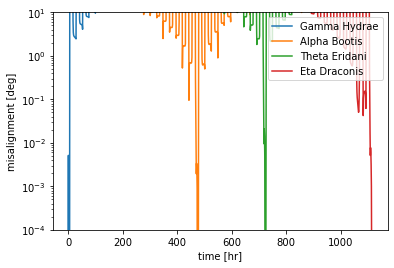

In [13]:
for ts in target_stars:
    star_ra = np.radians(star_ras[ts])
    star_dec = np.radians(star_decs[ts])
    star_dir_x = np.cos(star_dec)*np.cos(star_ra)
    star_dir_y = np.cos(star_dec)*np.sin(star_ra)
    star_dir_z = np.sin(star_dec)
    
    misalignment = np.linalg.norm(directions - [[star_dir_x, star_dir_y, star_dir_z]], axis=1)
    plt.plot(np.degrees(misalignment), label=star_names[ts])
plt.ylim((1e-4,10))
plt.yscale("log")
plt.ylabel("misalignment [deg]")
plt.xlabel("time [hr]")
plt.legend(loc=1)

### Delta-v estimates for the LGS
Finally, we plot our estimates for the delta-v required to repoint the LGS to observe the given target stars. The total delta-v in this example is 270 m/s spread over 47 days and used to repoint to 3 target stars.

Text(0, 0.5, 'delta v [m/s]')

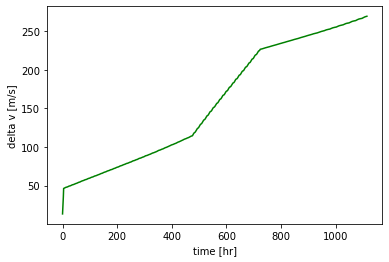

In [14]:
delta_v_lgs = np.linalg.norm(dvs_lgs, axis=1)

plt.plot(np.cumsum(delta_v_lgs), color="g")
plt.xlabel("time [hr]")
plt.ylabel("delta v [m/s]")